In [29]:
# %%
# ===================================================================
# PIPELINE : Two Layer LSTM -> TabNet -> Ridge
# TARGET: Minimize RMSE and SMAPE for IHSG Closing Price Prediction
# ===================================================================

# -------------------
# 1. Imports & Config
# -------------------
import yfinance as yf
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import optuna
import itertools
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import ttest_rel, norm

# Machine Learning Models
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from xgboost import XGBRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor

# Deep Learning Frameworks
import torch
from pytorch_tabnet.tab_model import TabNetRegressor
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization, Conv1D, MaxPooling1D, Flatten, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2, l1_l2

# Optuna for Hyperparameter Tuning
from optuna.pruners import MedianPruner
from optuna.exceptions import TrialPruned

# --- Global Configurations ---
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
tf.random.set_seed(42)
np.random.seed(42)
torch.manual_seed(42)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)

# %%
# ---------------------
# 2. Data Preparation
# ---------------------
print("--- Loading and Preparing Data ---")
start_date = "2010-01-01"
end_date = "2025-07-18"
# end_date = datetime.now().strftime('%Y-%m-%d')

variables = {
    # Indices
    "IHSG": "^JKSE",
    "S&P 500": "^GSPC",
    "Nasdaq": "^IXIC",
    "VIX": "^VIX",
    "Hang Seng Index": "^HSI",
    "DAX": "^GDAXI",
    # Commodities
    "Crude Oil (WTI)": "CL=F",
    "Crude Oil (Brent)": "BZ=F",
    "Gold": "GC=F",
    "Silver": "SI=F",
    "Copper": "HG=F",
    # "Natural Gas": "NG=F",
    # Forex
    "USD/IDR": "IDR=X",
    "EUR/USD": "EURUSD=X"
}
data_ohlc = yf.download(list(variables.values()), start=start_date, end=end_date, auto_adjust=False)

data = data_ohlc['Close'].copy()
volume = data_ohlc['Volume'].copy()
data.rename(columns={v: k for k, v in variables.items()}, inplace=True)
volume.rename(columns={v: f"{k}_Volume" for k, v in variables.items()}, inplace=True)

try:
    fed_rate = web.DataReader('FEDFUNDS', 'fred', start=start_date, end=end_date)
    data = data.join(fed_rate)
    data.rename(columns={'FEDFUNDS': 'Federal Funds Rate (Effective)'}, inplace=True)
    variables["Federal Funds Rate (Effective)"] = "Federal Funds Rate (Effective)"
except Exception as e:
    print(f"Could not fetch FEDFUNDS data. Error: {e}")

data = data.join(volume)
data.dropna(axis=1, how='all', inplace=True)
data = data.ffill().bfill()

# --- Feature Engineering ---
print("\n--- Performing Advanced Feature Engineering ---")
exp1 = data['IHSG'].ewm(span=12, adjust=False).mean()
exp2 = data['IHSG'].ewm(span=26, adjust=False).mean()
data['MACD_12_26_9'] = exp1 - exp2
data['MACDs_12_26_9'] = data['MACD_12_26_9'].ewm(span=9, adjust=False).mean()
data['MACDh_12_26_9'] = data['MACD_12_26_9'] - data['MACDs_12_26_9']
delta = data['IHSG'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI_14'] = 100 - (100 / (1 + rs))
data['BBM_20_2.0'] = data['IHSG'].rolling(window=20).mean()
std_dev = data['IHSG'].rolling(window=20).std()
data['BBU_20_2.0'] = data['BBM_20_2.0'] + (std_dev * 2)
data['BBL_20_2.0'] = data['BBM_20_2.0'] - (std_dev * 2)

for col in variables.keys():
    if col != 'IHSG' and col in data.columns:
        for lag in [1, 2, 3, 5, 10, 21]:
            data[f'{col}_pct_change_{lag}d'] = data[col].pct_change(lag)

data['Gold_vs_SP500'] = data['Gold'] / data['S&P 500']
data['DayOfWeek'] = data.index.dayofweek
data['Month'] = data.index.month
data['WeekOfYear'] = data.index.isocalendar().week.astype(int)
data['DayOfYear'] = data.index.dayofyear
data.dropna(inplace=True)

# %%
# ---------------------------
# 3. Data for Price Prediction
# ---------------------------
data['Target'] = data['IHSG'].shift(-1)
data.dropna(inplace=True)

features = [col for col in data.columns if col not in ['Target', 'IHSG']]
X = data[features]
y = data['Target']

categorical_cols = ['DayOfWeek', 'Month', 'WeekOfYear', 'DayOfYear']
categorical_idxs = [features.index(col) for col in categorical_cols]
categorical_dims = [len(X[col].unique()) for col in categorical_cols]

train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# --- ADDED: Data Shape Summary ---
print(f"[{data.shape[0]} rows x {data.shape[1]} columns] Featured data")
print(f"Total data rows after feature engineering and cleaning: {len(X)}")
print(f"Total training data rows: {len(X_train)}")
print(f"Total test data rows: {len(X_test)}")


scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1,1))

[***********           23%                       ]  3 of 13 completed

--- Loading and Preparing Data ---


[*********************100%***********************]  13 of 13 completed



--- Performing Advanced Feature Engineering ---
[4031 rows x 118 columns] Featured data
Total data rows after feature engineering and cleaning: 4031
Total training data rows: 3224
Total test data rows: 807


In [30]:
# %%
# -----------------------------------
# 4. Improved LSTM Model
# -----------------------------------
print("\n--- Training Improved LSTM Model ---")

def create_sequences(X, y, time_steps):
    X_seq, y_seq = [], []
    for i in range(time_steps, len(X)):
        X_seq.append(X[i-time_steps:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

def select_best_features_lstm(X_train, y_train, features, k=30):
    selector = SelectKBest(score_func=f_regression, k=k)
    X_selected = selector.fit_transform(X_train, y_train)
    selected_features = [features[i] for i in selector.get_support(indices=True)]
    return X_selected, selected_features, selector

def find_optimal_time_steps(X_train, y_train, test_lengths=[20, 40, 60, 80]):
    best_score = float('inf')
    best_length = 60
    for length in test_lengths:
        if len(X_train) <= length: continue
        X_seq, y_seq = create_sequences(X_train, y_train, length)
        if len(X_seq) < 200: continue
        inputs = Input(shape=(X_seq.shape[1], X_seq.shape[2]))
        x = LSTM(100)(inputs)
        x = Dropout(0.2)(x)
        outputs = Dense(1)(x)
        test_model = Model(inputs=inputs, outputs=outputs)
        test_model.compile(optimizer=Adam(0.001), loss='mse')
        history = test_model.fit(
            X_seq[:800], y_seq[:800], epochs=15, batch_size=32,
            validation_split=0.2, verbose=0,
            callbacks=[EarlyStopping(patience=5)]
        )
        val_loss = min(history.history['val_loss'])
        if val_loss < best_score:
            best_score, best_length = val_loss, length
        del test_model
        tf.keras.backend.clear_session()
    return best_length

X_train_selected, selected_features_lstm, feature_selector = select_best_features_lstm(
    X_train_scaled, y_train_scaled.ravel(), features, k=30
)
X_test_selected = feature_selector.transform(X_test_scaled)
print(f"Selected {len(selected_features_lstm)} features for LSTM:")
print(selected_features_lstm)


TIME_STEPS = find_optimal_time_steps(X_train_selected, y_train_scaled)
print(f"Optimal TIME_STEPS: {TIME_STEPS}")

X_train_seq, y_train_seq = create_sequences(X_train_selected, y_train_scaled, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test_selected, y_test_scaled, TIME_STEPS)


--- Training Improved LSTM Model ---
Selected 30 features for LSTM:
['Crude Oil (Brent)', 'Crude Oil (WTI)', 'EUR/USD', 'Gold', 'USD/IDR', 'Silver', 'DAX', 'S&P 500', 'Hang Seng Index', 'Nasdaq', 'VIX', 'Federal Funds Rate (Effective)', 'Crude Oil (Brent)_Volume', 'Crude Oil (WTI)_Volume', 'DAX_Volume', 'S&P 500_Volume', 'Hang Seng Index_Volume', 'Nasdaq_Volume', 'IHSG_Volume', 'MACD_12_26_9', 'MACDs_12_26_9', 'BBM_20_2.0', 'BBU_20_2.0', 'BBL_20_2.0', 'Crude Oil (WTI)_pct_change_21d', 'Crude Oil (Brent)_pct_change_21d', 'Federal Funds Rate (Effective)_pct_change_5d', 'Federal Funds Rate (Effective)_pct_change_10d', 'Federal Funds Rate (Effective)_pct_change_21d', 'Gold_vs_SP500']
Optimal TIME_STEPS: 20


In [31]:
def walk_forward_splits(X, y, n_splits=3):
    n_samples = len(X)
    min_train_size = int(n_samples * 0.6)
    step_size = (n_samples - min_train_size) // n_splits
    splits = []
    for i in range(n_splits):
        train_end = min_train_size + (i * step_size)
        test_start = train_end
        test_end = min(train_end + step_size, n_samples)
        if test_end > n_samples or test_start >= test_end: break
        splits.append((np.arange(0, train_end), np.arange(test_start, test_end)))
    return splits

def objective_lstm(trial):
    units1 = trial.suggest_categorical('units1', [128, 256, 512])
    units2 = trial.suggest_categorical('units2', [64, 128, 256])
    dropout1 = trial.suggest_float('dropout1', 0.1, 0.3)
    dropout2 = trial.suggest_float('dropout2', 0.1, 0.3)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    use_batch_norm = trial.suggest_categorical('use_batch_norm', [True, False])
    
    splits = walk_forward_splits(X_train_seq, y_train_seq)
    fold_scores = []
    for train_idx, val_idx in splits:
        inputs = Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2]))
        x = LSTM(units1, return_sequences=True, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-5))(inputs)
        if use_batch_norm: x = BatchNormalization()(x)
        x = Dropout(dropout1)(x)
        x = LSTM(units2, return_sequences=False, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-5))(x)
        if use_batch_norm: x = BatchNormalization()(x)
        x = Dropout(dropout2)(x)
        outputs = Dense(1)(x)
        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(lr), loss=tf.keras.losses.Huber(delta=1.0))
        history = model.fit(
            X_train_seq[train_idx], y_train_seq[train_idx],
            validation_data=(X_train_seq[val_idx], y_train_seq[val_idx]),
            epochs=50, batch_size=batch_size, verbose=0,
            callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
        )
        fold_scores.append(min(history.history['val_loss']))
        del model
        tf.keras.backend.clear_session()
    return np.mean(fold_scores)

# --- Run or Define LSTM Hyperparameters ---
# study_lstm = optuna.create_study(direction='minimize')
# study_lstm.optimize(objective_lstm, n_trials=20)
# best_lstm_params = study_lstm.best_params
# print(f"\nBest LSTM Params Found ===> {best_lstm_params}")


Using Pre-defined LSTM Params ===> {'units1': 128, 'units2': 64, 'dropout1': 0.11241963286717759, 'dropout2': 0.13336023336812003, 'lr': 0.005207147481858353, 'batch_size': 16, 'use_batch_norm': False}
Epoch 1/250
170/171 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0766 - mae: 0.1592
Epoch 1: val_loss improved from inf to 0.02036, saving model to best_lstm_model.keras
171/171 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0761 - mae: 0.1582 - val_loss: 0.0204 - val_mae: 0.0665 - learning_rate: 0.0052
Epoch 2/250
170/171 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0162 - mae: 0.0438
Epoch 2: val_loss improved from 0.02036 to 0.01201, saving model to best_lstm_model.keras
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0162 - mae: 0.0437 - val_loss: 0.0120 - val_mae: 0.0553 - learning_rate: 0.0052
Epoch 3/250
170/171 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0096 - mae: 0.0355
Epoch 3: val_loss improved from 0.01201 to 0.00867, saving model to best_lstm_model.keras
171/171 ━━━━━━━━━━

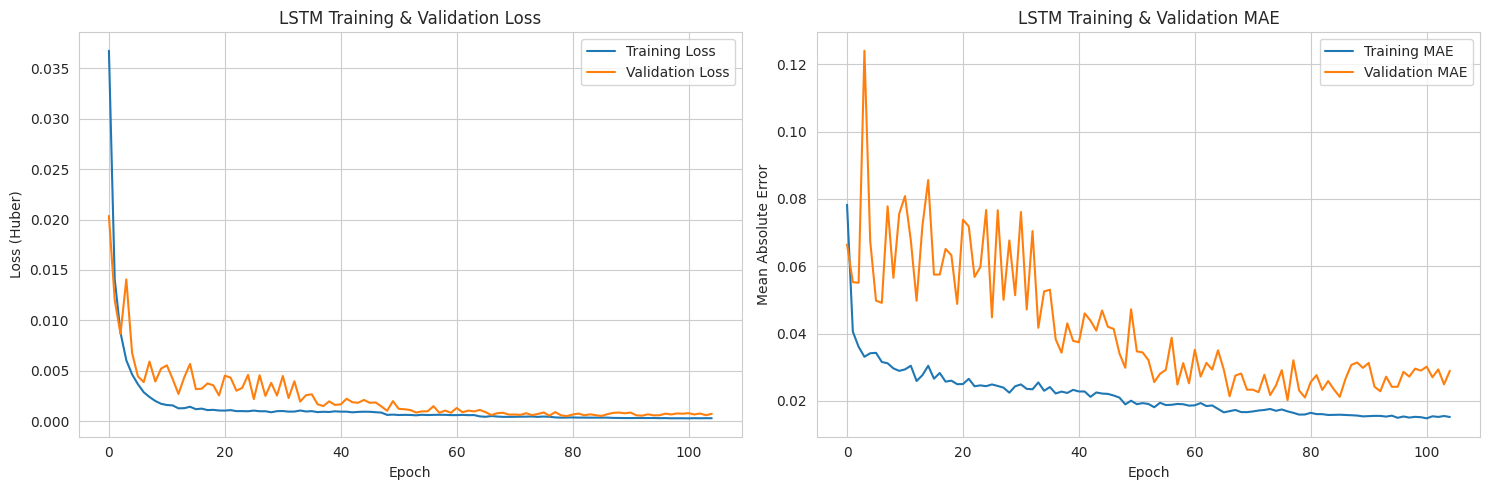

In [32]:
# NOTE: Uncomment the block below and comment out the study above to use pre-defined parameters
best_lstm_params = {
    'units1': 128, 
    'units2': 64, 
    'dropout1': 0.11241963286717759, 
    'dropout2': 0.13336023336812003, 
    'lr': 0.005207147481858353, 
    'batch_size': 16, 
    'use_batch_norm': False
}
print(f"\nUsing Pre-defined LSTM Params ===> {best_lstm_params}")

# --- Build and Train Final LSTM Model ---
inputs = Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2]))
x = LSTM(best_lstm_params['units1'], return_sequences=True, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-5))(inputs)
if best_lstm_params.get('use_batch_norm', False): x = BatchNormalization()(x)
x = Dropout(best_lstm_params['dropout1'])(x)
x = LSTM(best_lstm_params['units2'], return_sequences=False, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-5))(x)
if best_lstm_params.get('use_batch_norm', False): x = BatchNormalization()(x)
x = Dropout(best_lstm_params['dropout2'])(x)
outputs = Dense(1)(x)
final_lstm = Model(inputs=inputs, outputs=outputs)
final_lstm.compile(optimizer=Adam(best_lstm_params['lr']), loss=tf.keras.losses.Huber(delta=1.0), metrics=['mae'])
callbacks = [
    EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6),
    ModelCheckpoint('best_lstm_model.keras', save_best_only=True, monitor='val_loss', verbose=1)
]
history = final_lstm.fit(
    X_train_seq, y_train_seq, epochs=250, batch_size=best_lstm_params.get('batch_size', 32),
    validation_split=0.15, callbacks=callbacks, verbose=1
)
lstm_pred_train_scaled = final_lstm.predict(X_train_seq)
lstm_pred_test_scaled = final_lstm.predict(X_test_seq)
# --- ADDED: Training Visualization for Final LSTM Model ---

print("\n--- Visualizing Final LSTM Training History ---")
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Huber)')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('LSTM Training & Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
# %%
# ------------------------------------------------------
# 5. TabNet Model
# ------------------------------------------------------
print("\n--- Training TabNet Model with Optuna ---")
X_train_tabular = X_train_scaled[TIME_STEPS:]
X_test_tabular = X_test_scaled[TIME_STEPS:]
y_train_tabular = y_train_seq
y_test_tabular = y_test_seq
print(f"TabNet model is using all {X_train_tabular.shape[1]} available features.")

def objective_tabnet(trial):
    params = {
        'n_d': trial.suggest_categorical('n_d', [64, 128, 256]),
        'n_a': trial.suggest_categorical('n_a', [64, 128, 256]),
        'n_steps': trial.suggest_categorical('n_steps', [5, 6, 7, 8]),
        'gamma': trial.suggest_float('gamma', 1.0, 2.0),
        'lambda_sparse': trial.suggest_float('lambda_sparse', 1e-6, 1e-3, log=True),
        'mask_type': trial.suggest_categorical('mask_type', ['sparsemax', 'entmax']),
        'cat_idxs': categorical_idxs, 'cat_dims': categorical_dims,
        'cat_emb_dim': trial.suggest_int("cat_emb_dim", 1, 3),
        'optimizer_fn': torch.optim.Adam,
        'optimizer_params': dict(lr=trial.suggest_float('lr', 1e-3, 3e-2, log=True)),
    }
    model = TabNetRegressor(**params, seed=42, verbose=0)
    model.fit(
        X_train=X_train_tabular, y_train=y_train_tabular, 
        eval_set=[(X_test_tabular, y_test_tabular)], eval_metric=['mse'], 
        max_epochs=200, patience=30, batch_size=128, virtual_batch_size=64
    )
    return model.best_cost

# --- Run or Define TabNet Hyperparameters ---
# study_tabnet = optuna.create_study(direction='minimize')
# study_tabnet.optimize(objective_tabnet, n_trials=30)
# best_tabnet_params = study_tabnet.best_params
# print("\n--- Best TabNet Parameters Found by Optuna ---")
# print(best_tabnet_params)


--- Training TabNet Model with Optuna ---
TabNet model is using all 116 available features.



Using Pre-defined TabNet Params ===> {'n_d': 128, 'n_a': 64, 'n_steps': 6, 'gamma': 1.4111155446660746, 'lambda_sparse': 0.0005010346459713968, 'mask_type': 'entmax', 'cat_emb_dim': 3, 'optimizer_params': {'lr': 0.01867060603587282}}
epoch 0  | loss: 9.70248 | val_0_mse: 0.28201 | val_0_mae: 0.50042 |  0:00:02s
epoch 2  | loss: 1.12978 | val_0_mse: 0.3234  | val_0_mae: 0.5615  |  0:00:06s
epoch 4  | loss: 0.06349 | val_0_mse: 0.0626  | val_0_mae: 0.24029 |  0:00:11s
epoch 6  | loss: 0.01551 | val_0_mse: 0.02346 | val_0_mae: 0.14343 |  0:00:15s
epoch 8  | loss: 0.01676 | val_0_mse: 0.00795 | val_0_mae: 0.07898 |  0:00:19s
epoch 10 | loss: 0.01053 | val_0_mse: 0.04511 | val_0_mae: 0.20696 |  0:00:23s
epoch 12 | loss: 0.00781 | val_0_mse: 0.00136 | val_0_mae: 0.03044 |  0:00:28s
epoch 14 | loss: 0.00692 | val_0_mse: 0.01092 | val_0_mae: 0.09724 |  0:00:35s
epoch 16 | loss: 0.00516 | val_0_mse: 0.00683 | val_0_mae: 0.07246 |  0:00:40s
epoch 18 | loss: 0.00463 | val_0_mse: 0.00308 | val_0_

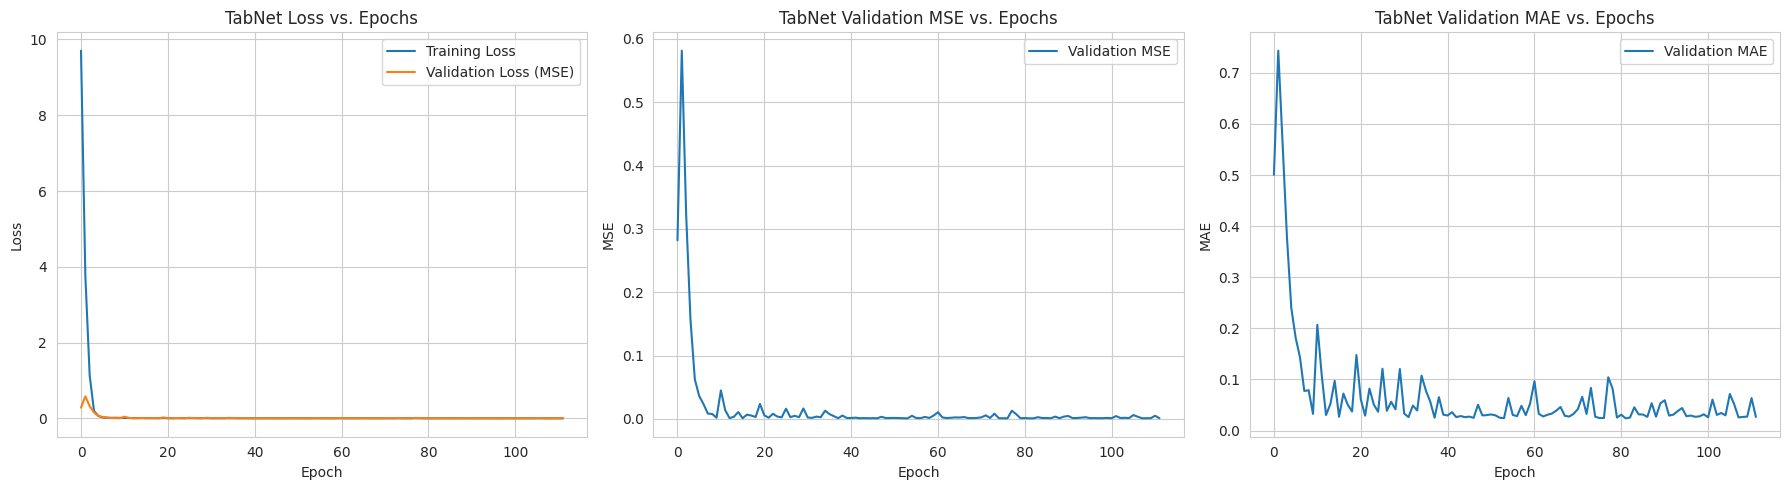

In [ ]:
# NOTE: Uncomment the block below and comment out the study above to use pre-defined parameters
best_tabnet_params = {
    'n_d': 128, 
    'n_a': 64, 
    'n_steps': 6, 
    'gamma': 1.4111155446660746, 
    'lambda_sparse': 0.0005010346459713968, 
    'mask_type': 'entmax', 
    'cat_emb_dim': 3, 
    'optimizer_params': {'lr': 0.01867060603587282}
}
print(f"\nUsing Pre-defined TabNet Params ===> {best_tabnet_params}")

# --- Build and Train Final TabNet Model ---
final_tabnet = TabNetRegressor(**best_tabnet_params, seed=42, verbose=2)
final_tabnet.fit(
    X_train=X_train_tabular, y_train=y_train_tabular, 
    eval_set=[(X_test_tabular, y_test_tabular)], eval_metric=['mse', 'mae'], 
    max_epochs=250, patience=30, batch_size=128, virtual_batch_size=64
)
tabnet_pred_train_scaled = final_tabnet.predict(X_train_tabular).reshape(-1, 1)
tabnet_pred_test_scaled = final_tabnet.predict(X_test_tabular).reshape(-1, 1)

# --- ADDED: Training Visualization for Final TabNet Model ---
print("\n--- Visualizing Final TabNet Training History ---")
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(final_tabnet.history['loss'], label='Training Loss')
plt.plot(final_tabnet.history['val_0_mse'], label='Validation Loss (MSE)')
plt.title('TabNet Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.subplot(1, 3, 2)
plt.plot(final_tabnet.history['val_0_mse'], label='Validation MSE')
plt.title('TabNet Validation MSE vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.subplot(1, 3, 3)
plt.plot(final_tabnet.history['val_0_mae'], label='Validation MAE')
plt.title('TabNet Validation MAE vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


--- Visualizing Final TabNet Training History ---


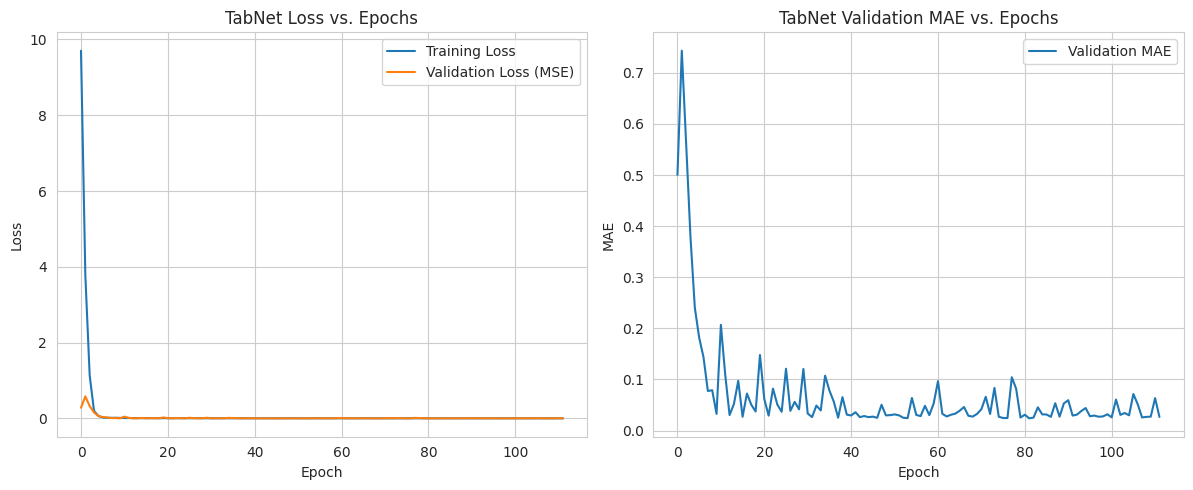

In [50]:
print("\n--- Visualizing Final TabNet Training History ---")
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(final_tabnet.history['loss'], label='Training Loss')
plt.plot(final_tabnet.history['val_0_mse'], label='Validation Loss (MSE)')
plt.title('TabNet Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(final_tabnet.history['val_0_mae'], label='Validation MAE')
plt.title('TabNet Validation MAE vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
# %%
# -----------------------------------
# 6. Ridge Meta Learner
# -----------------------------------
print("\n--- Training Ridge Ensemble Model ---")
meta_train = np.hstack([X_train_tabular, lstm_pred_train_scaled, tabnet_pred_train_scaled])
meta_test = np.hstack([X_test_tabular, lstm_pred_test_scaled, tabnet_pred_test_scaled])
meta_model = Ridge(alpha=1.0)
meta_model.fit(meta_train, y_train_tabular.ravel())
final_pred_scaled = meta_model.predict(meta_test)


--- Training Ridge Ensemble Model ---



--- Final Combined Model Metrics ---
                    Model        RMSE         MAE        R2  SMAPE (%)
0         Standalone LSTM  137.267894  108.329456  0.783303   1.552962
1                  TabNet  152.017465  115.000939  0.734233   1.645219
2  Ensemble (LSTM+TabNet)   85.629703   61.414406  0.915674   0.880164


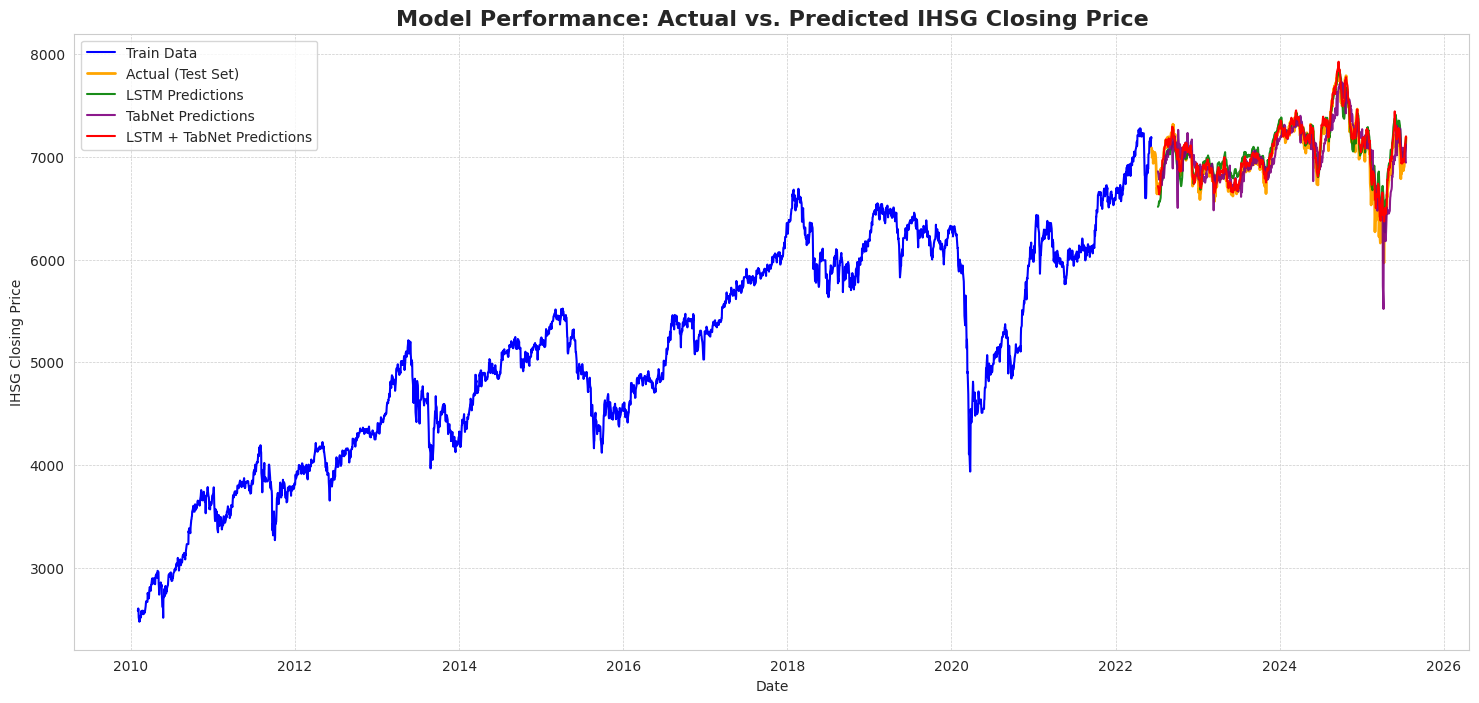

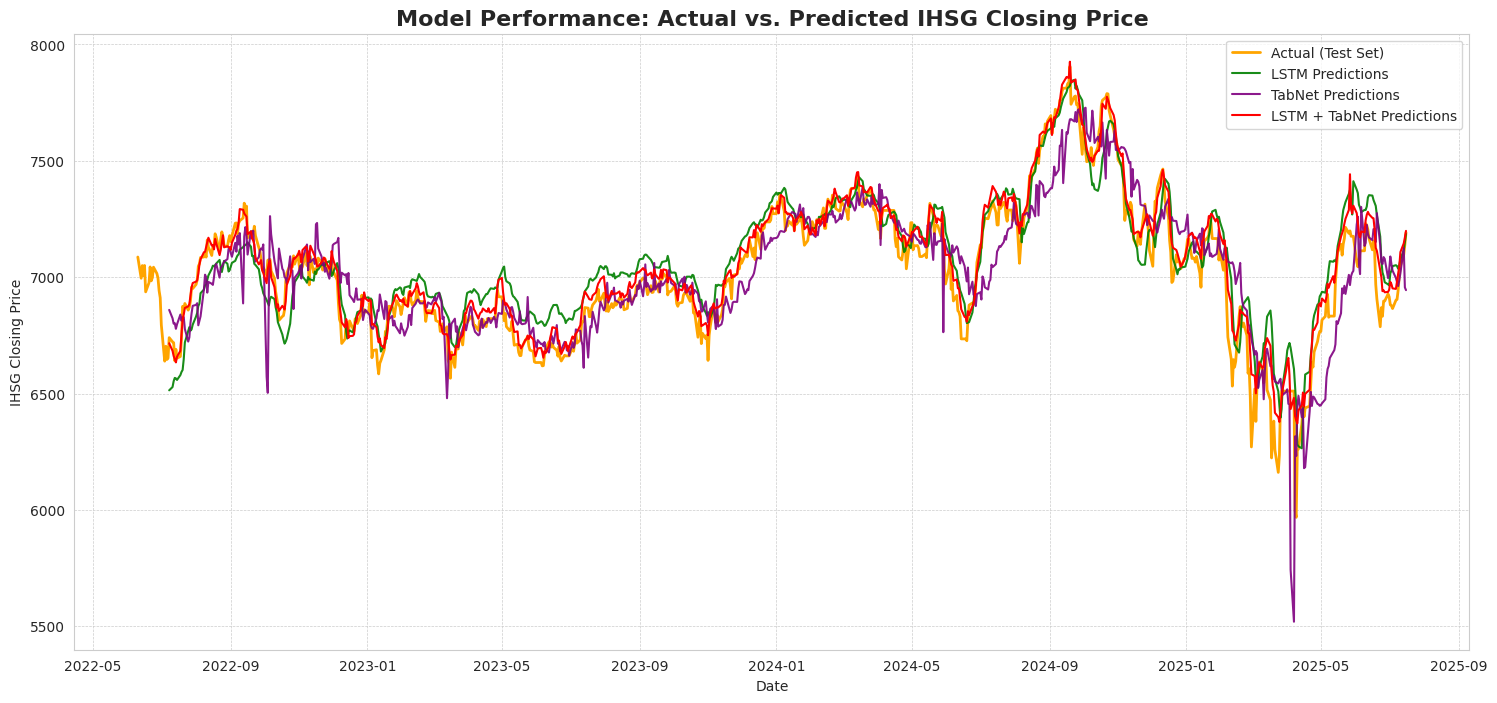

In [36]:
# %%
# ------------------------------
# 7. Reconstruct actual prices & Evaluate
# ------------------------------
final_pred = scaler_y.inverse_transform(final_pred_scaled.reshape(-1, 1)).flatten()
lstm_pred = scaler_y.inverse_transform(lstm_pred_test_scaled).flatten()
tabnet_pred = scaler_y.inverse_transform(tabnet_pred_test_scaled).flatten()
y_test_actual = y_test.iloc[TIME_STEPS:].values

def calculate_metrics(y_true, y_pred, model_name="Final Model"):
    metrics = {'Model': model_name, 'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)), 'MAE': mean_absolute_error(y_true, y_pred), 'R2': r2_score(y_true, y_pred), 'SMAPE (%)': 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true)/(np.abs(y_true) + np.abs(y_pred) + 1e-8))}
    return metrics

metrics_final = calculate_metrics(y_test_actual, final_pred, "Ensemble (LSTM+TabNet)")
metrics_lstm = calculate_metrics(y_test_actual, lstm_pred, "Standalone LSTM")
metrics_tabnet = calculate_metrics(y_test_actual, tabnet_pred, "TabNet")
results_df = pd.DataFrame([metrics_lstm, metrics_tabnet,metrics_final])

print("\n--- Final Combined Model Metrics ---")
print(results_df.to_string())

# --- REVISED PLOTTING LOGIC TO REMOVE GAP ---
train_data = data[:train_size]
valid_data = data[train_size:].copy()
prediction_dates = y_test.index[TIME_STEPS:]
valid_data['Predictions'] = np.nan
valid_data.loc[prediction_dates, 'Predictions'] = final_pred
valid_data['LSTM_Predictions'] = np.nan
valid_data.loc[prediction_dates, 'LSTM_Predictions'] = lstm_pred
valid_data['TabNet_Predictions'] = np.nan
valid_data.loc[prediction_dates, 'TabNet_Predictions'] = tabnet_pred


# Plotting
plt.figure(figsize=(18, 8))
plt.title('Model Performance: Actual vs. Predicted IHSG Closing Price', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('IHSG Closing Price')
plt.plot(train_data['IHSG'], label='Train Data', color='blue')
plt.plot(valid_data['IHSG'], label='Actual (Test Set)', color='orange', linewidth=2)
plt.plot(valid_data['LSTM_Predictions'], label='LSTM Predictions', color='green', alpha=0.9)
plt.plot(valid_data['TabNet_Predictions'], label='TabNet Predictions', color='purple', alpha=0.9)
plt.plot(valid_data['Predictions'], label='LSTM + TabNet Predictions', color='red')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# without the training data
plt.figure(figsize=(18, 8))
plt.title('Model Performance: Actual vs. Predicted IHSG Closing Price', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('IHSG Closing Price')
plt.plot(valid_data['IHSG'], label='Actual (Test Set)', color='orange', linewidth=2)
plt.plot(valid_data['LSTM_Predictions'], label='LSTM Predictions', color='green', alpha=0.9)
plt.plot(valid_data['TabNet_Predictions'], label='TabNet Predictions', color='purple', alpha=0.9)
plt.plot(valid_data['Predictions'], label='LSTM + TabNet Predictions', color='red')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


Performing TabNet categorical analysis...

--- Top 15 Overall Feature Importance (TabNet) ---
                                           Feature  Importance
30                                      BBM_20_2.0    0.404286
102                          EUR/USD_pct_change_5d    0.112259
31                                      BBU_20_2.0    0.060778
6                                           Silver    0.044057
4                                           Copper    0.034559
82                            Silver_pct_change_2d    0.032066
66                   Crude Oil (WTI)_pct_change_5d    0.030814
92                           Copper_pct_change_21d    0.029515
99                           EUR/USD_pct_change_1d    0.020414
1                                  Crude Oil (WTI)    0.019092
43                           Nasdaq_pct_change_10d    0.017073
10                                          Nasdaq    0.016212
55                  Hang Seng Index_pct_change_10d    0.014892
84                     

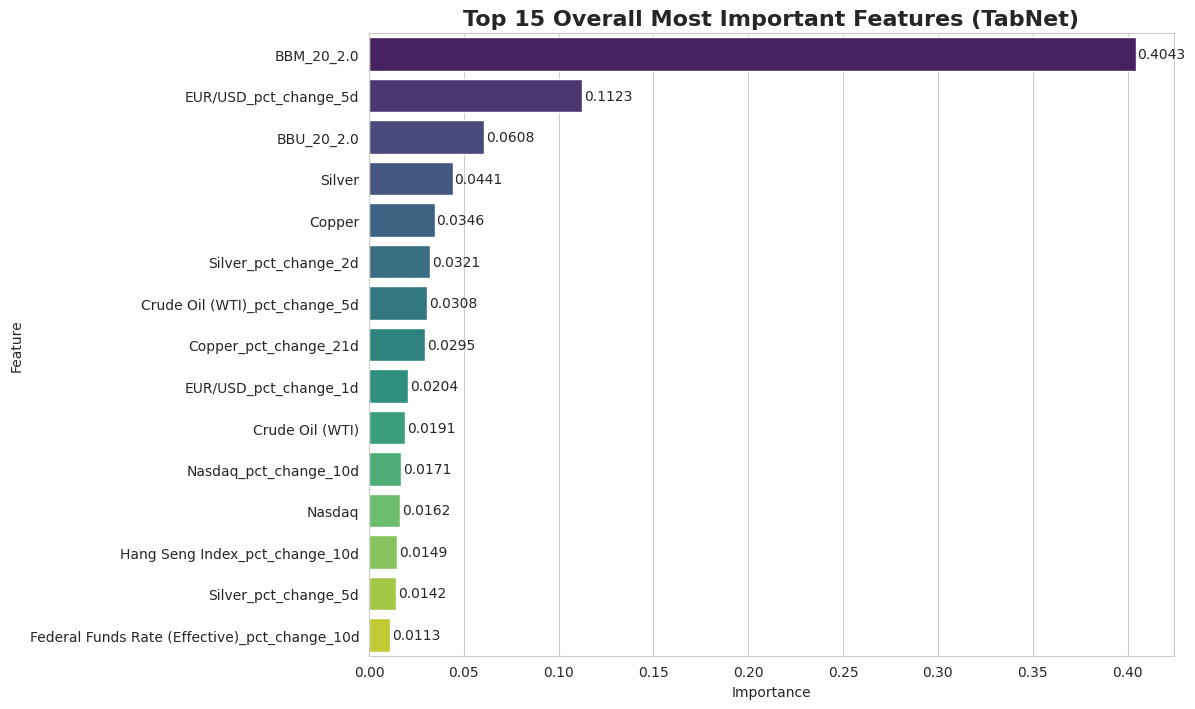

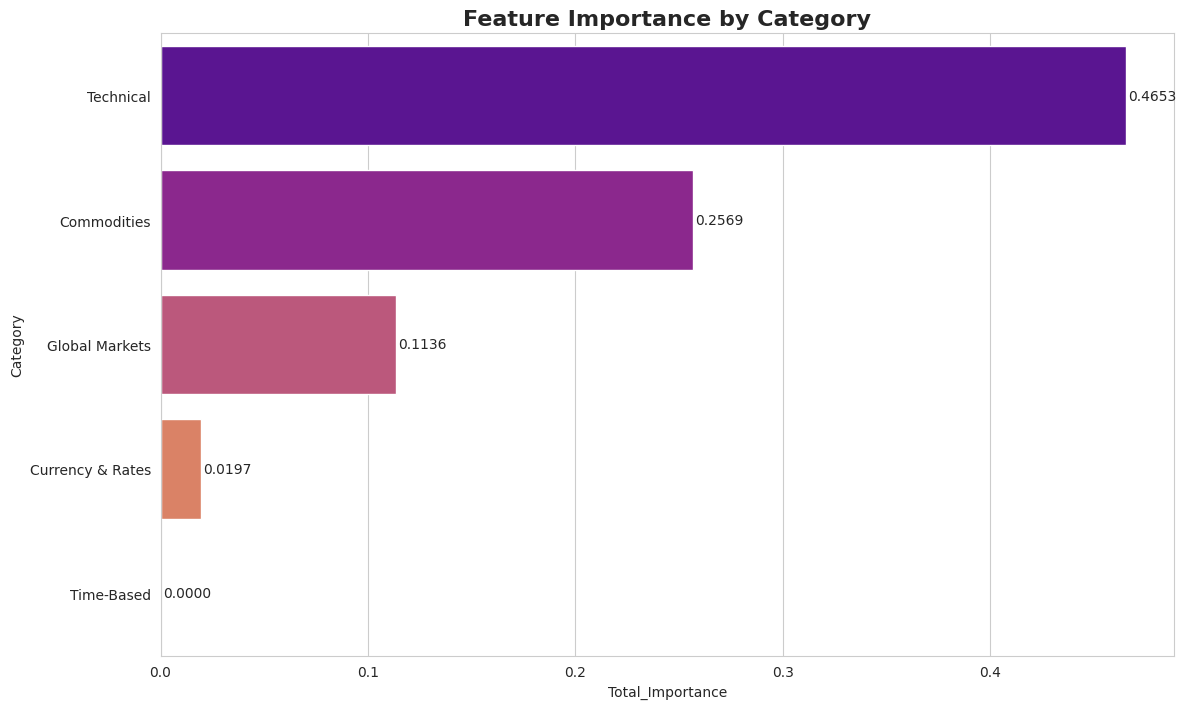

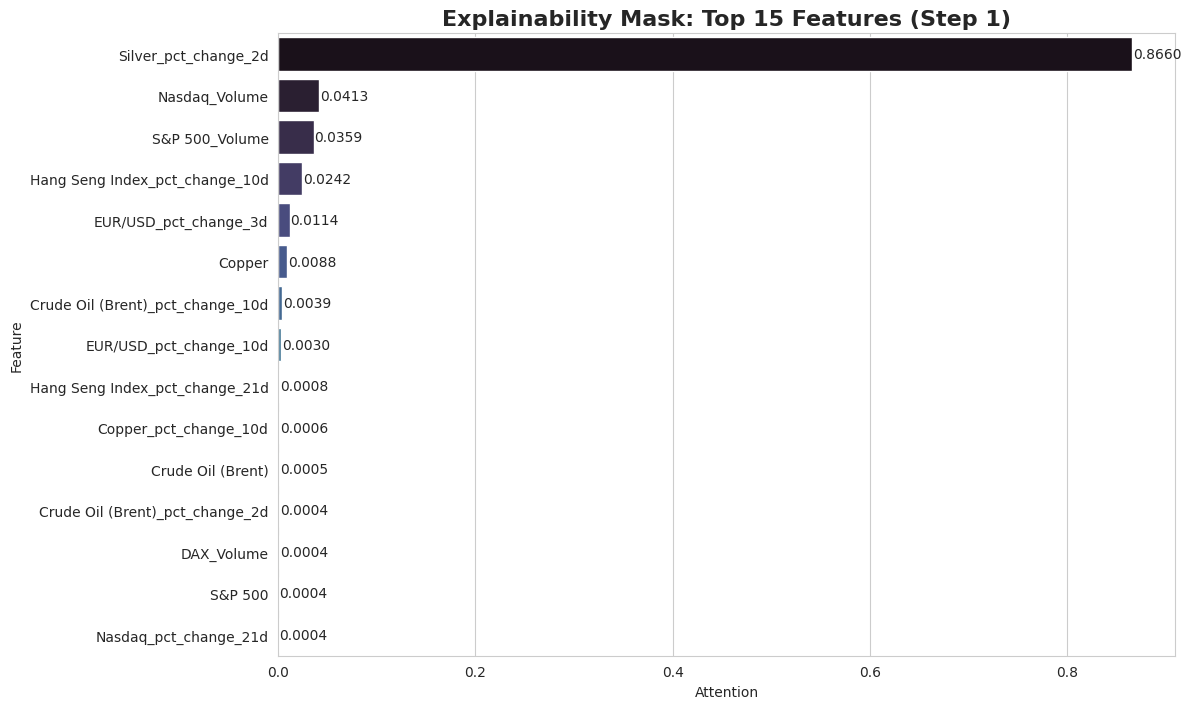

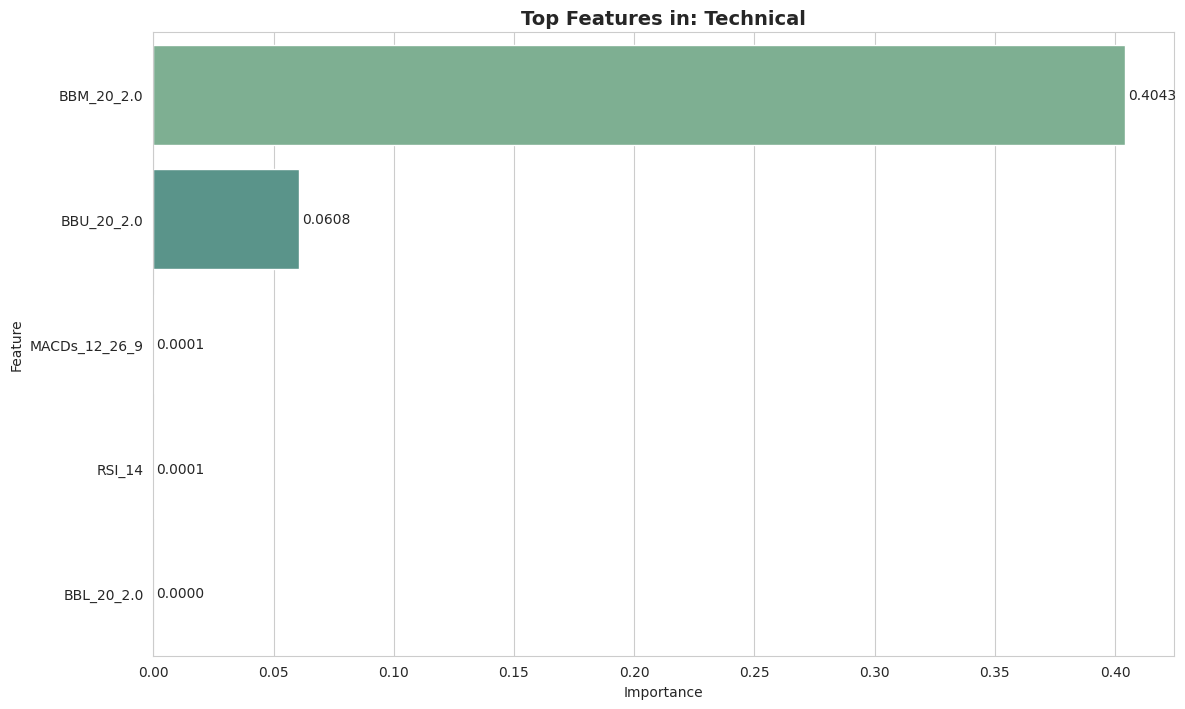

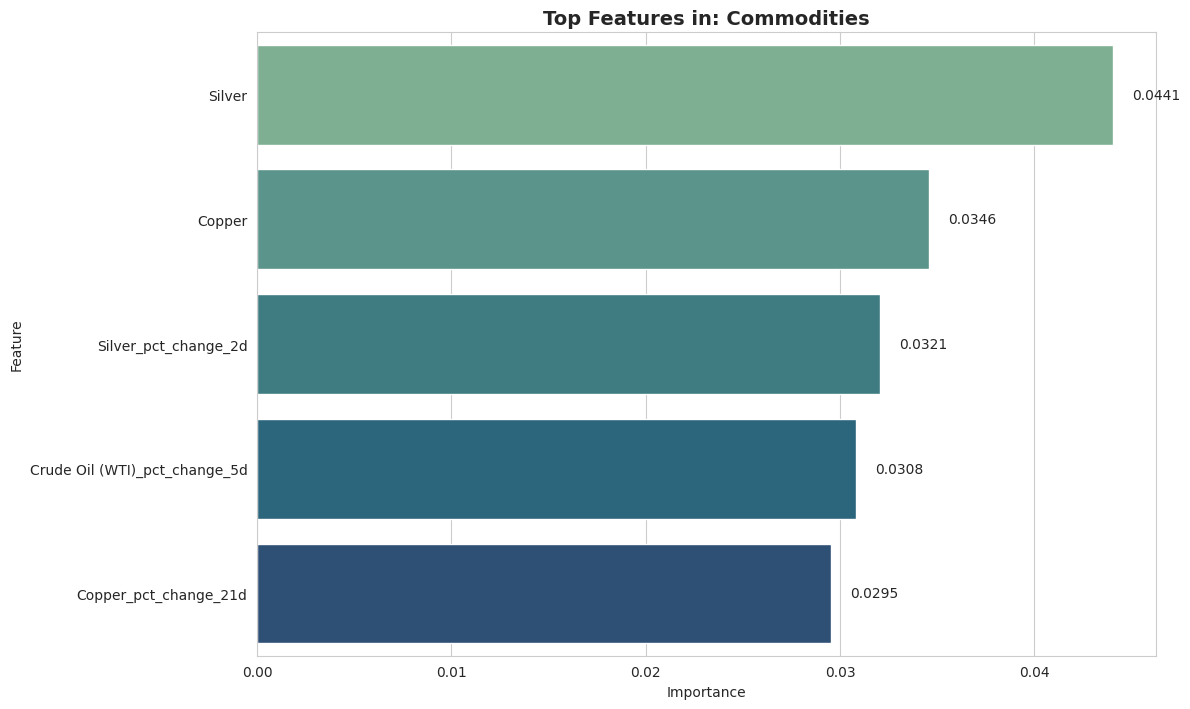

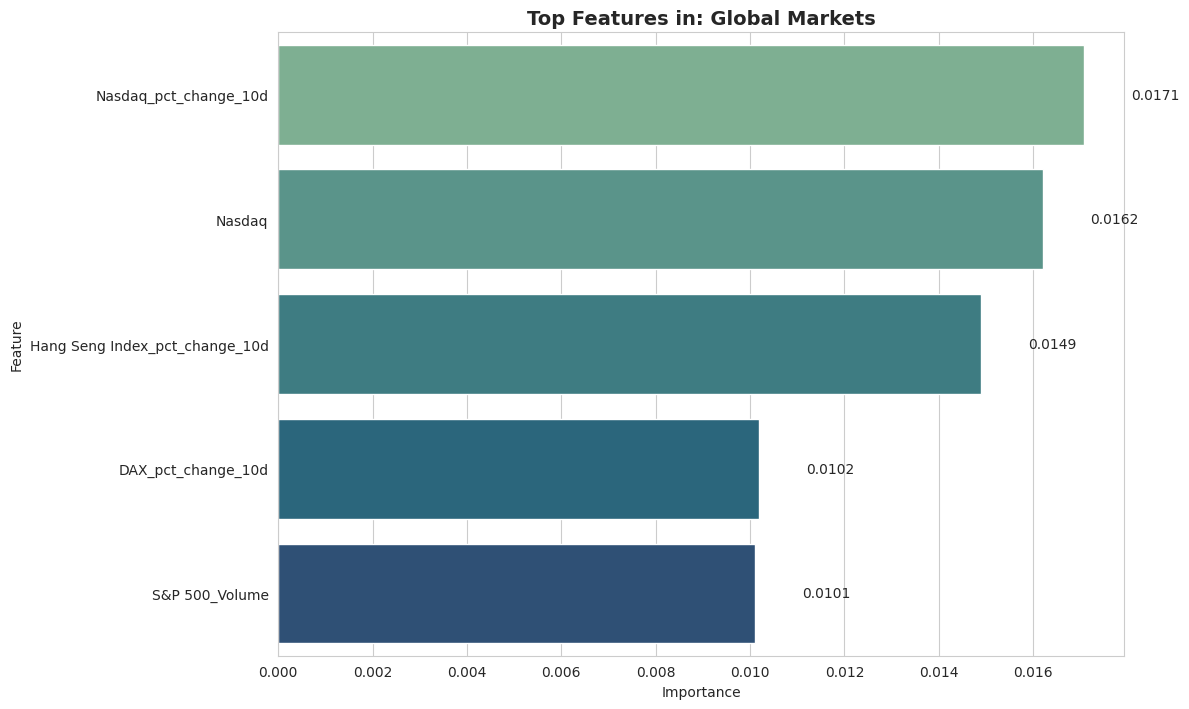

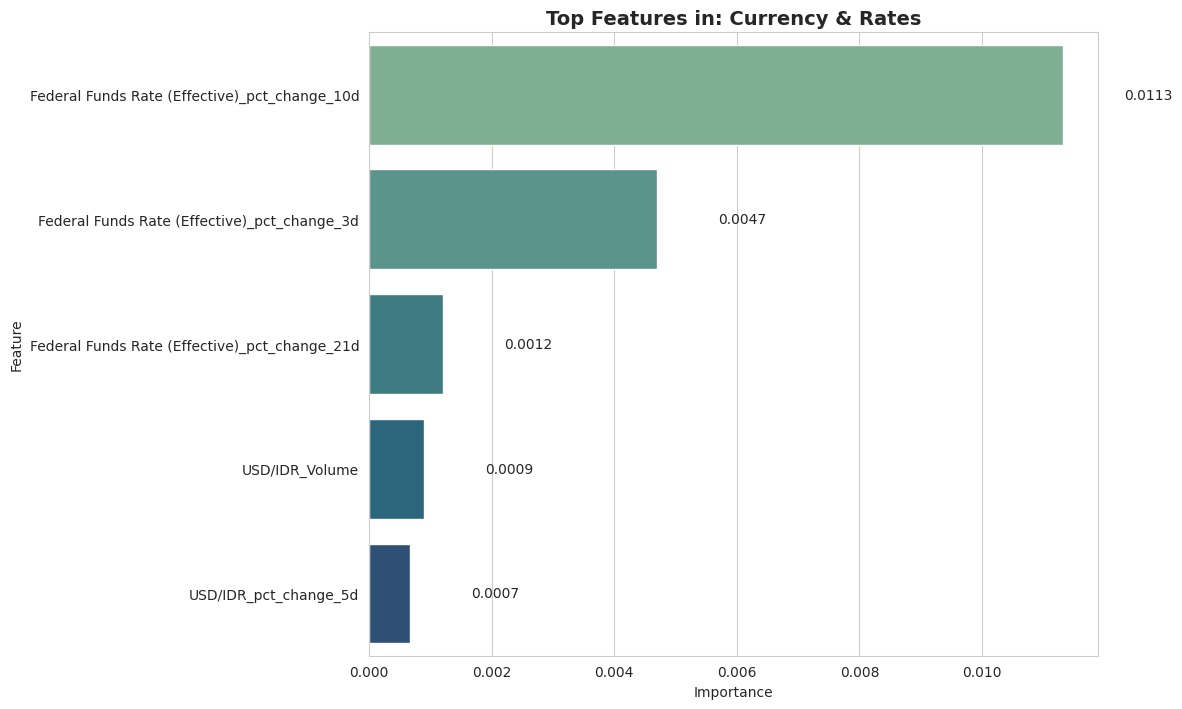

In [41]:
# %%
# ===================================================================
# 8. TabNet Feature Importance & Categorical Analysis (RESTORED)
# ===================================================================
print("\nPerforming TabNet categorical analysis...")

importance_df = pd.DataFrame({'Feature': features, 'Importance': final_tabnet.feature_importances_}).sort_values('Importance', ascending=False)

categories_map = {
    'Technical': [c for c in features if any(x in c for x in ['RSI', 'ATR', 'MACD', 'BBL', 'BBM', 'BBU'])],
    'Global Markets': [f for f in features if any(m in f for m in ['S&P 500', 'Nasdaq', 'DAX', 'VIX', 'Hang Seng'])],
    'Commodities': [f for f in features if any(m in f for m in ['Crude Oil', 'Gold', 'Copper', 'Silver'])],
    'Currency & Rates': [f for f in features if any(m in f for m in ['IDR', 'EURUSD', 'Federal Funds Rate'])],
    'Time-Based': ['DayOfWeek', 'Month', 'WeekOfYear']
}

category_importance = {}
for category, cat_features in categories_map.items():
    existing_features = [f for f in cat_features if f in importance_df['Feature'].values]
    category_importance[category] = importance_df[importance_df['Feature'].isin(existing_features)]['Importance'].sum()

category_df = pd.DataFrame(list(category_importance.items()), columns=['Category', 'Total_Importance']).sort_values('Total_Importance', ascending=False)

# --- ADDED: Print statements for the data behind the plots ---
print("\n--- Top 15 Overall Feature Importance (TabNet) ---")
print(importance_df.head(15).to_string())
print("\n--- Feature Importance by Category ---")
print(category_df.to_string())


# --- Visualization Dashboard (Each plot on its own figure) ---
FIGURE_WIDTH = 12 
FIGURE_HEIGHT_RATIO = 0.6 

# Plot 1: Overall Top 15 Features
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_WIDTH * FIGURE_HEIGHT_RATIO))
top_15_overall = importance_df.head(15)
ax1 = sns.barplot(data=top_15_overall, x='Importance', y='Feature', palette='viridis')
ax1.set_title('Top 15 Overall Most Important Features (TabNet)', fontsize=16, fontweight='bold')
for p in ax1.patches:
    width = p.get_width()
    ax1.text(width + 0.001, p.get_y() + p.get_height() / 2, f'{width:.4f}', va='center')
plt.tight_layout()
plt.show()

# Plot 2: Importance by Category
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_WIDTH * FIGURE_HEIGHT_RATIO))
ax2 = sns.barplot(data=category_df, x='Total_Importance', y='Category', palette='plasma')
ax2.set_title('Feature Importance by Category', fontsize=16, fontweight='bold')
for p in ax2.patches:
    width = p.get_width()
    ax2.text(width + 0.001, p.get_y() + p.get_height() / 2, f'{width:.4f}', va='center')
plt.tight_layout()
plt.show()

# --- UPDATED: Readable Explainability Mask Visualization ---
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_WIDTH * FIGURE_HEIGHT_RATIO))
explain_matrix, masks = final_tabnet.explain(X_test_tabular)
mask_step1_avg = np.mean(masks[0], axis=0)
mask_df = pd.DataFrame({'Feature': features, 'Attention': mask_step1_avg}).sort_values('Attention', ascending=False)
ax3 = sns.barplot(data=mask_df.head(15), x='Attention', y='Feature', palette='mako')
ax3.set_title('Explainability Mask: Top 15 Features (Step 1)', fontsize=16, fontweight='bold')
for p in ax3.patches:
    width = p.get_width()
    ax3.text(width + 0.001, p.get_y() + p.get_height() / 2, f'{width:.4f}', va='center')
plt.tight_layout()
plt.show()


top_categories = category_df['Category'].head(4).tolist()
for i, category in enumerate(top_categories):
    plt.figure(figsize=(FIGURE_WIDTH, FIGURE_WIDTH * FIGURE_HEIGHT_RATIO))
    cat_features = categories_map.get(category, [])
    cat_df = importance_df[importance_df['Feature'].isin(cat_features)].head(5)
    ax = sns.barplot(data=cat_df, x='Importance', y='Feature', palette='crest')
    ax.set_title(f'Top Features in: {category}', fontsize=14, fontweight='bold')
    for p in ax.patches:
        width = p.get_width()
        ax.text(width + 0.001, p.get_y() + p.get_height() / 2, f'{width:.4f}', va='center')
    plt.tight_layout()
    plt.show()


In [42]:
# %%
# ===================================================================
# 9. Statistical Significance Testing
# ===================================================================
print("\n" + "=" * 60)
print("STATISTICAL SIGNIFICANCE TESTING")
print("=" * 60)

def diebold_mariano_test(actual, pred1, pred2, h=1):
    e1 = actual - pred1
    e2 = actual - pred2
    d = e1**2 - e2**2
    d_mean = np.mean(d)
    # Corrected gamma calculation
    gamma = []
    for j in range(h):
        if j == 0:
            gamma.append(np.mean((d - d_mean)**2))
        else:
            gamma.append(np.mean((d[j:] - d_mean) * (d[:-j] - d_mean)))
    d_var = gamma[0] + 2 * np.sum(gamma[1:])
    dm_stat = d_mean / np.sqrt(d_var / len(d))
    p_value = 2 * (1 - norm.cdf(np.abs(dm_stat)))
    return dm_stat, p_value

def bootstrap_metric_difference(y_true, pred1, pred2, metric_func, n_bootstrap=1000):
    n = len(y_true)
    differences = []
    for _ in range(n_bootstrap):
        idx = np.random.choice(n, size=n, replace=True)
        metric1 = metric_func(y_true[idx], pred1[idx])
        metric2 = metric_func(y_true[idx], pred2[idx])
        differences.append(metric1 - metric2)
    
    ci_lower = np.percentile(differences, 2.5)
    ci_upper = np.percentile(differences, 97.5)
    mean_diff = np.mean(differences)
    return ci_lower, ci_upper, mean_diff

def rmse_metric(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

# --- Diebold-Mariano Test ---
dm_tests = {
    "Ridge Ensemble vs. LSTM": diebold_mariano_test(y_test_actual, final_pred, lstm_pred),
    "Ridge Ensemble vs. TabNet": diebold_mariano_test(y_test_actual, final_pred, tabnet_pred)
}
for name, (stat, pval) in dm_tests.items():
    print(f"\n--- Diebold-Mariano Test: {name} ---")
    print(f"DM Statistic: {stat:.4f}, P-value: {pval:.4f}")
    if pval < 0.05 and stat < 0: print(f"  ✅ Ensemble forecast is significantly more accurate.")
    else: print(f"  ❌ No significant difference in forecast accuracy.")

# --- Bootstrap Test ---
print("\n" + "=" * 60)
print("BOOTSTRAP 95% CI FOR RMSE DIFFERENCE")
print("=" * 60)
bootstrap_tests = {
    "Ridge Ensemble vs. LSTM": bootstrap_metric_difference(y_test_actual, final_pred, lstm_pred, rmse_metric),
    "Ridge Ensemble vs. TabNet": bootstrap_metric_difference(y_test_actual, final_pred, tabnet_pred, rmse_metric)
}
for name, (ci_low, ci_high, mean_diff) in bootstrap_tests.items():
    print(f"\n--- {name} ---")
    print(f"Mean RMSE difference: {mean_diff:.4f} (95% CI: [{ci_low:.4f}, {ci_high:.4f}])")
    if ci_high < 0:
        print(f"  ✅ Ensemble is significantly better (CI is entirely below 0).")
    else:
        print(f"  ❌ No significant difference (CI includes 0).")


STATISTICAL SIGNIFICANCE TESTING

--- Diebold-Mariano Test: Ridge Ensemble vs. LSTM ---
DM Statistic: -15.7869, P-value: 0.0000
  ✅ Ensemble forecast is significantly more accurate.

--- Diebold-Mariano Test: Ridge Ensemble vs. TabNet ---
DM Statistic: -11.5454, P-value: 0.0000
  ✅ Ensemble forecast is significantly more accurate.

BOOTSTRAP 95% CI FOR RMSE DIFFERENCE

--- Ridge Ensemble vs. LSTM ---
Mean RMSE difference: -51.7851 (95% CI: [-56.0228, -47.7548])
  ✅ Ensemble is significantly better (CI is entirely below 0).

--- Ridge Ensemble vs. TabNet ---
Mean RMSE difference: -66.3404 (95% CI: [-75.9224, -57.2779])
  ✅ Ensemble is significantly better (CI is entirely below 0).



--- Training Enhanced Benchmark Models ---
Note: Benchmarks will use the same 30 features selected for the LSTM for a fair comparison.

--- Tuning XGBoost ---
Best params for XGBoost: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01}

--- Tuning LightGBM ---
Best params for LightGBM: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'verbose': -1}

--- Tuning RandomForest ---
Best params for RandomForest: {'n_estimators': 500, 'max_depth': 10}

--- Tuning CatBoost ---
Best params for CatBoost: {'iterations': 500, 'depth': 4, 'learning_rate': 0.05}

--- Training Deep Learning Benchmarks ---
Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0908 - val_loss: 0.0099
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 - val_loss: 0.0122
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - val_loss: 0.0105
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.2545e-04 - val_loss: 0.0084
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s

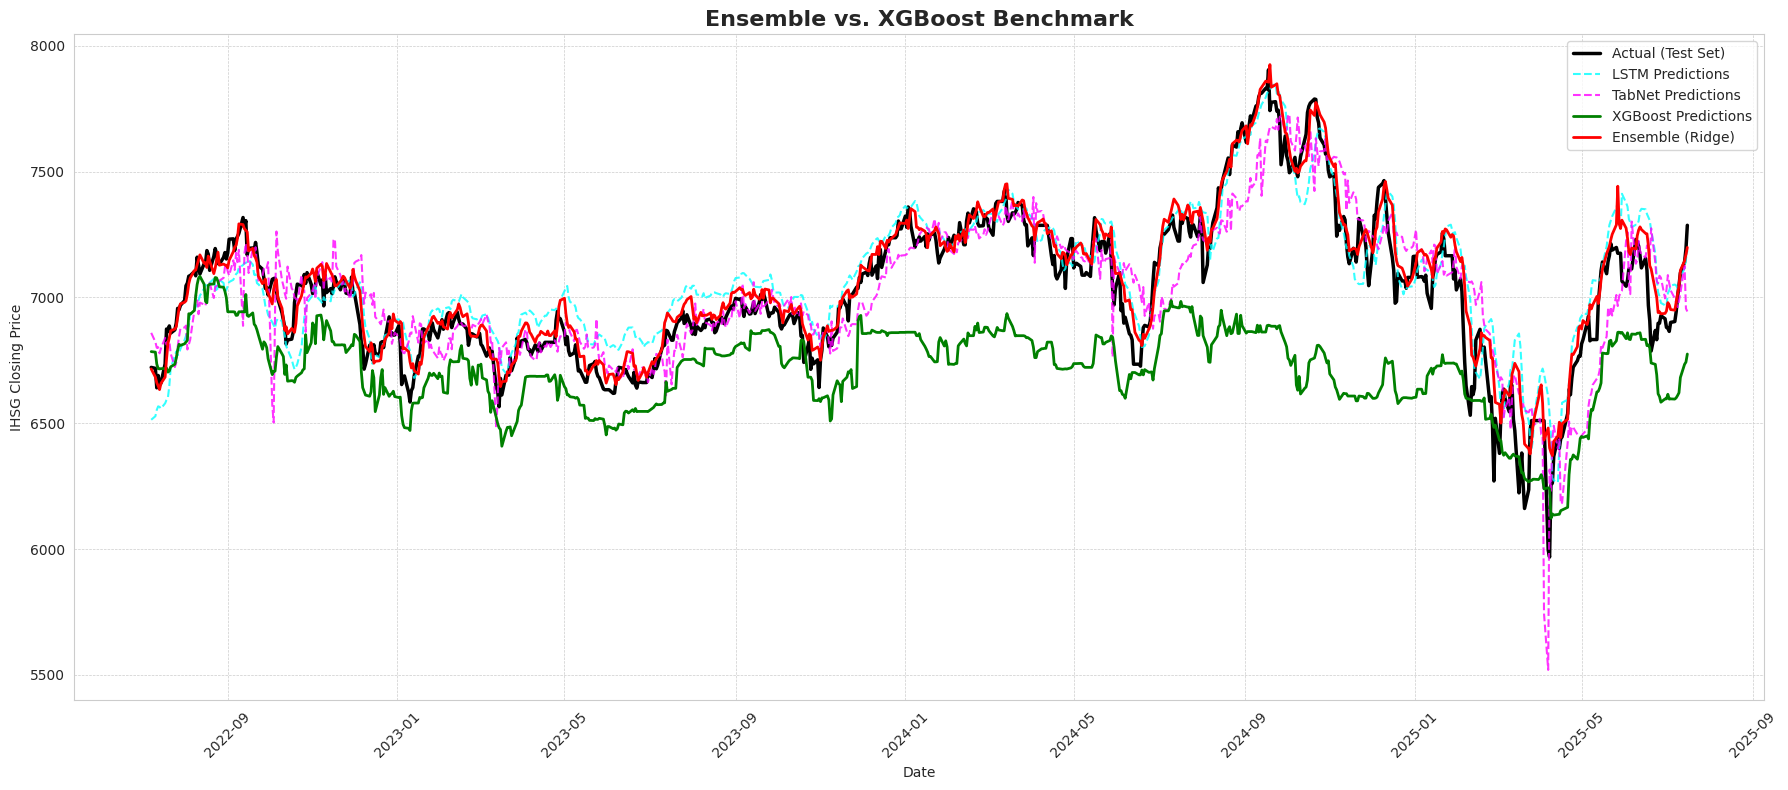

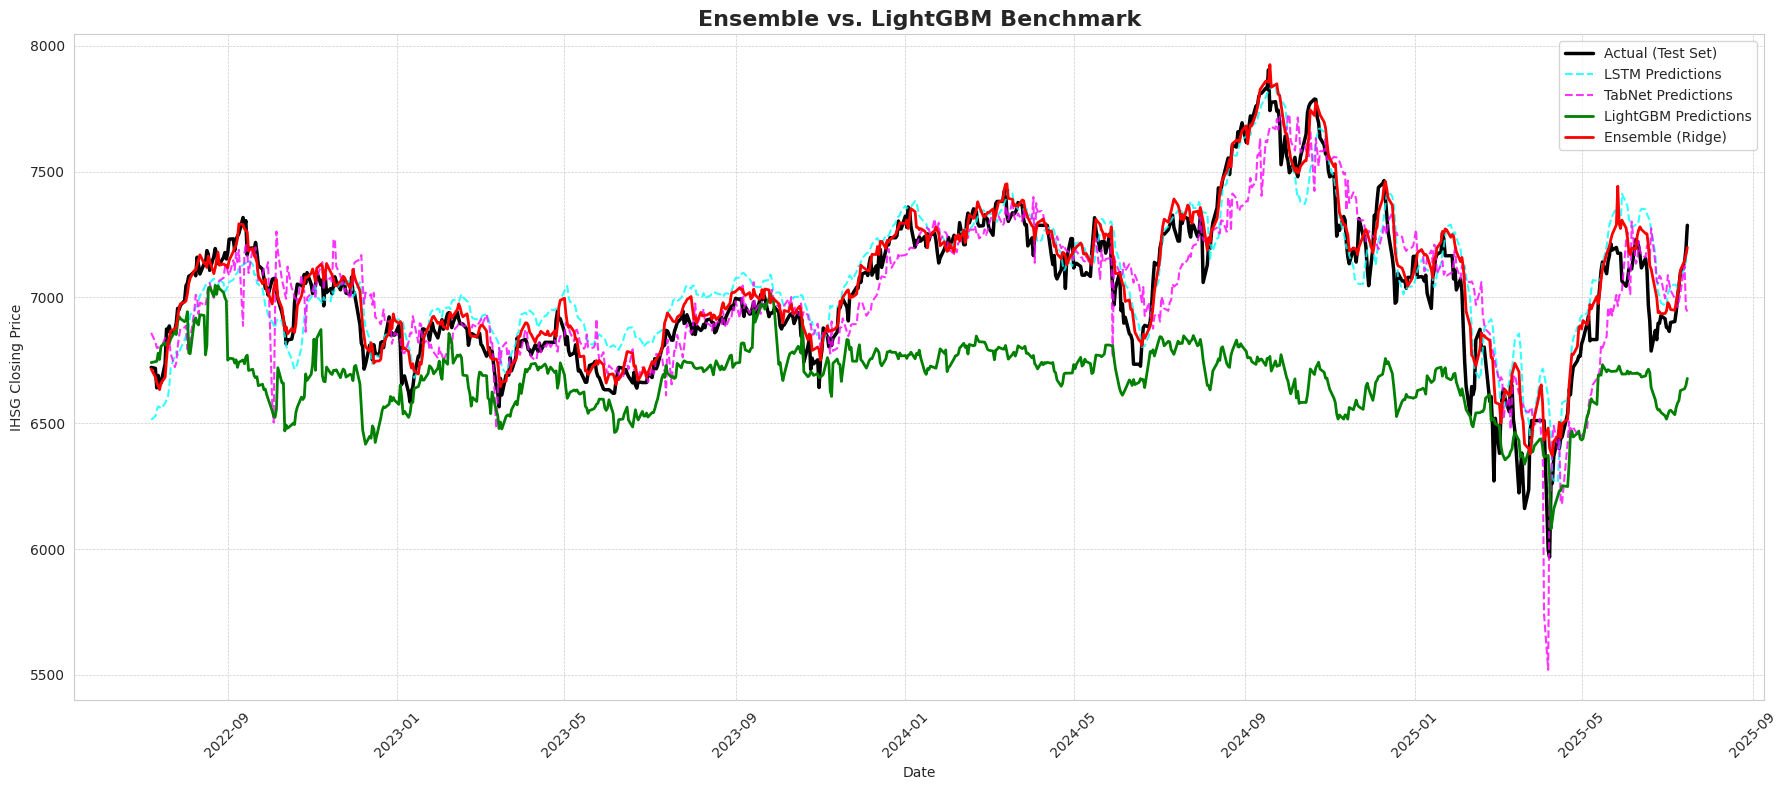

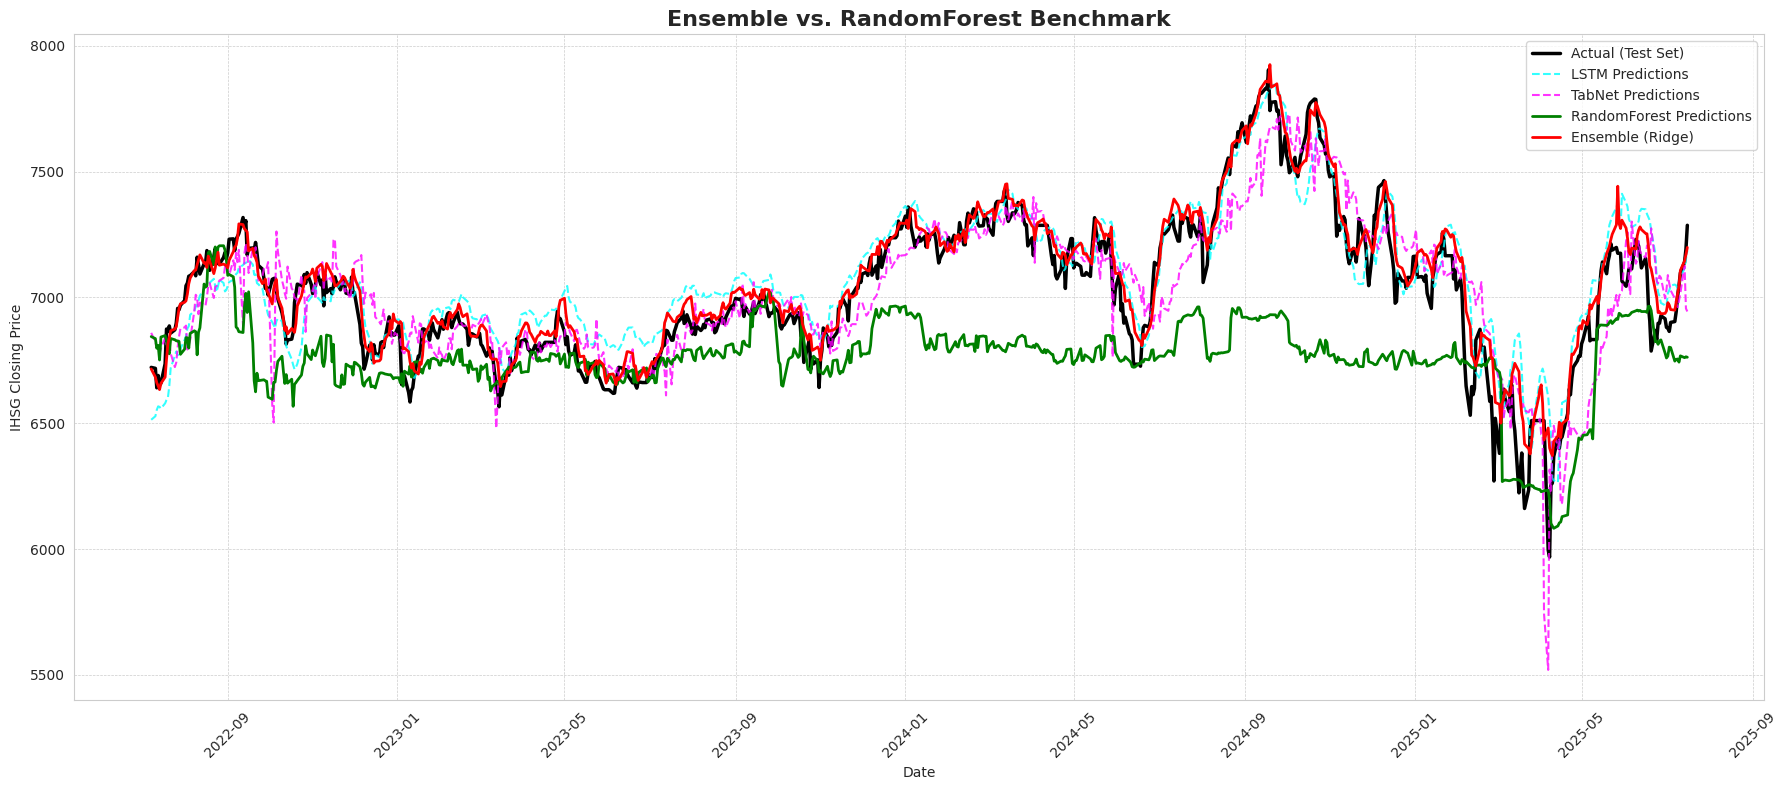

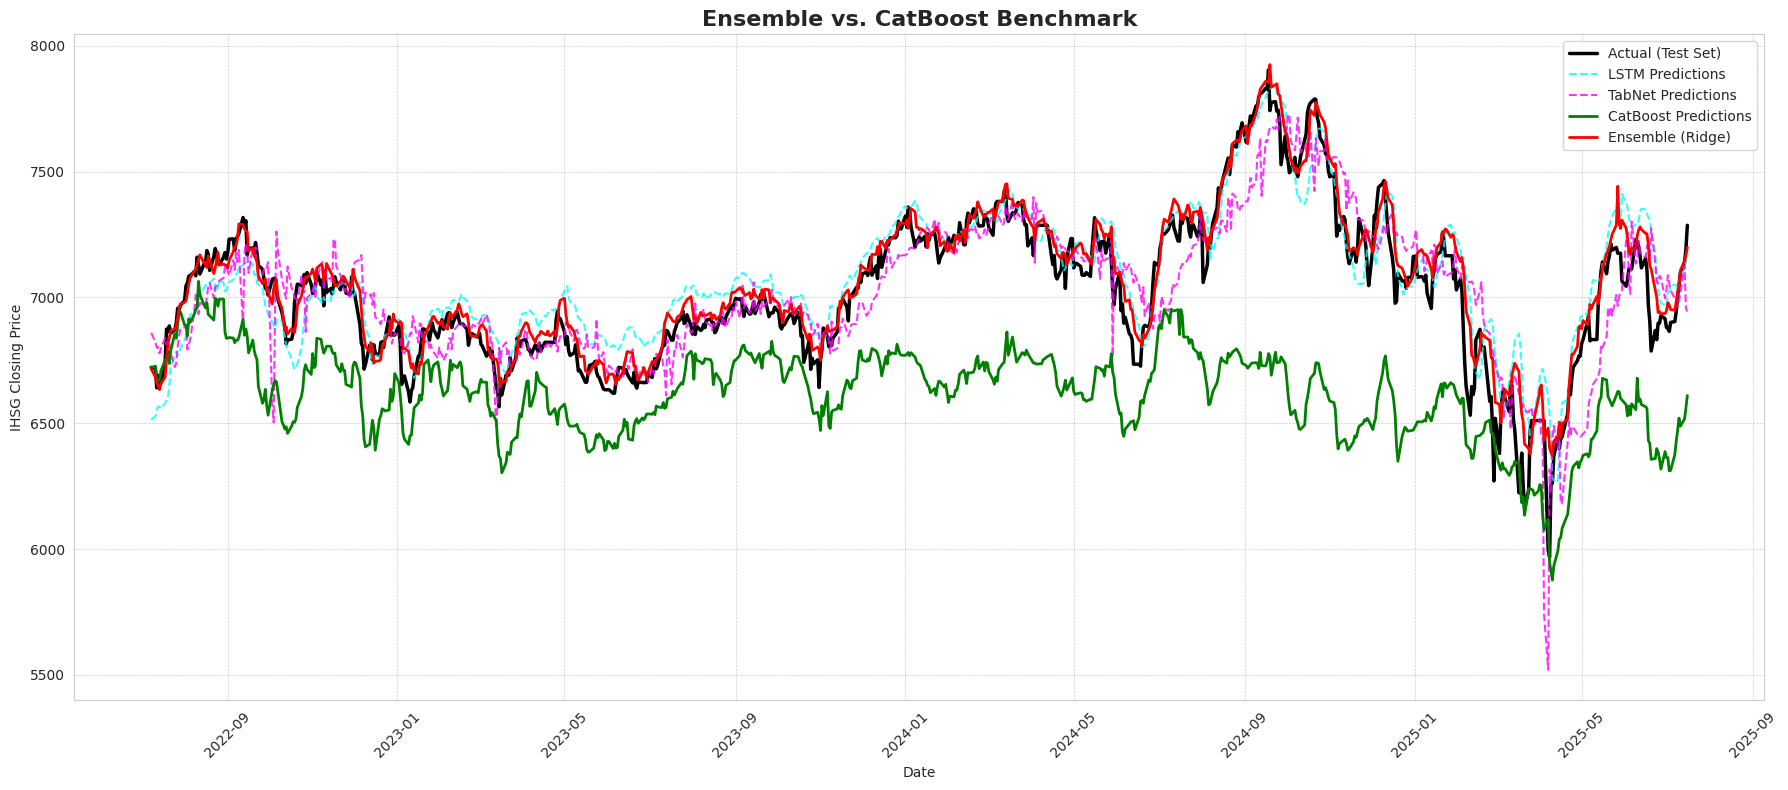

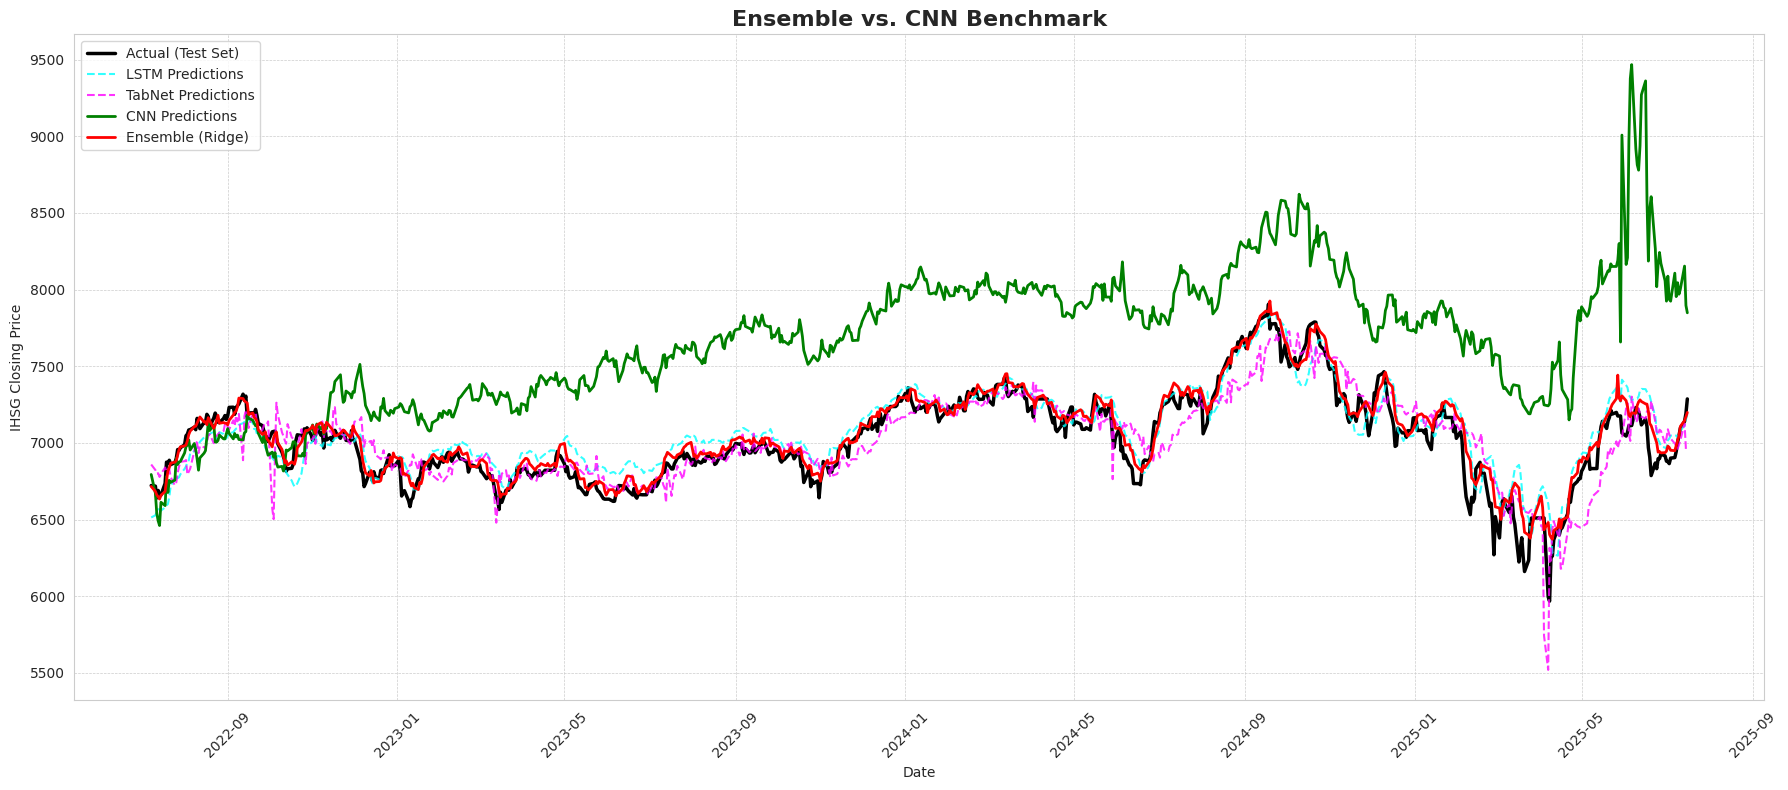

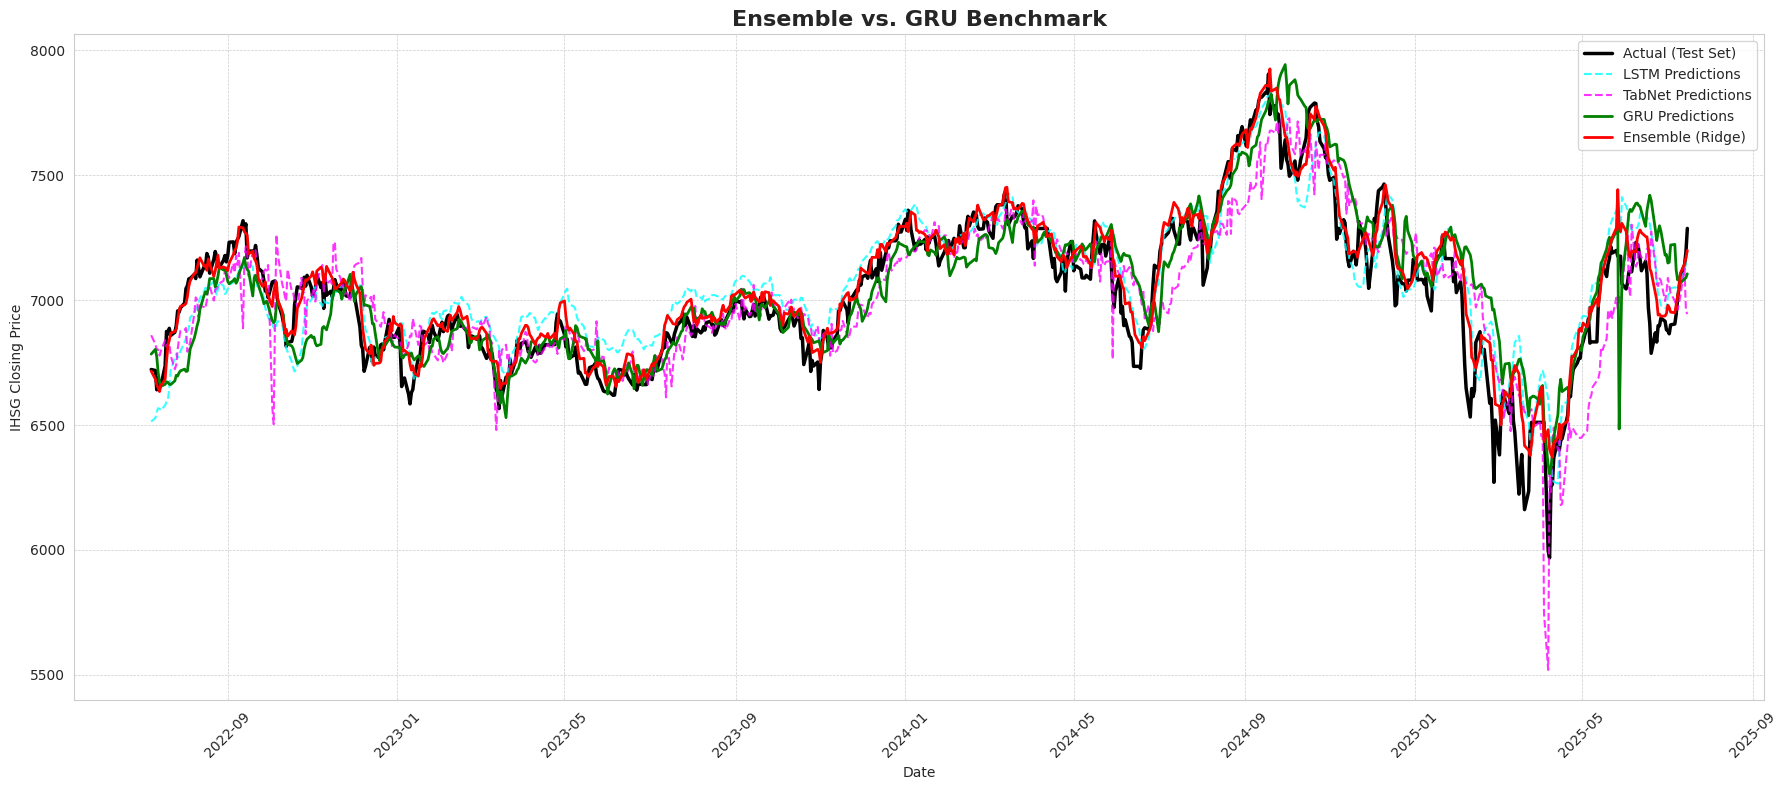

<Figure size 1500x1000 with 0 Axes>

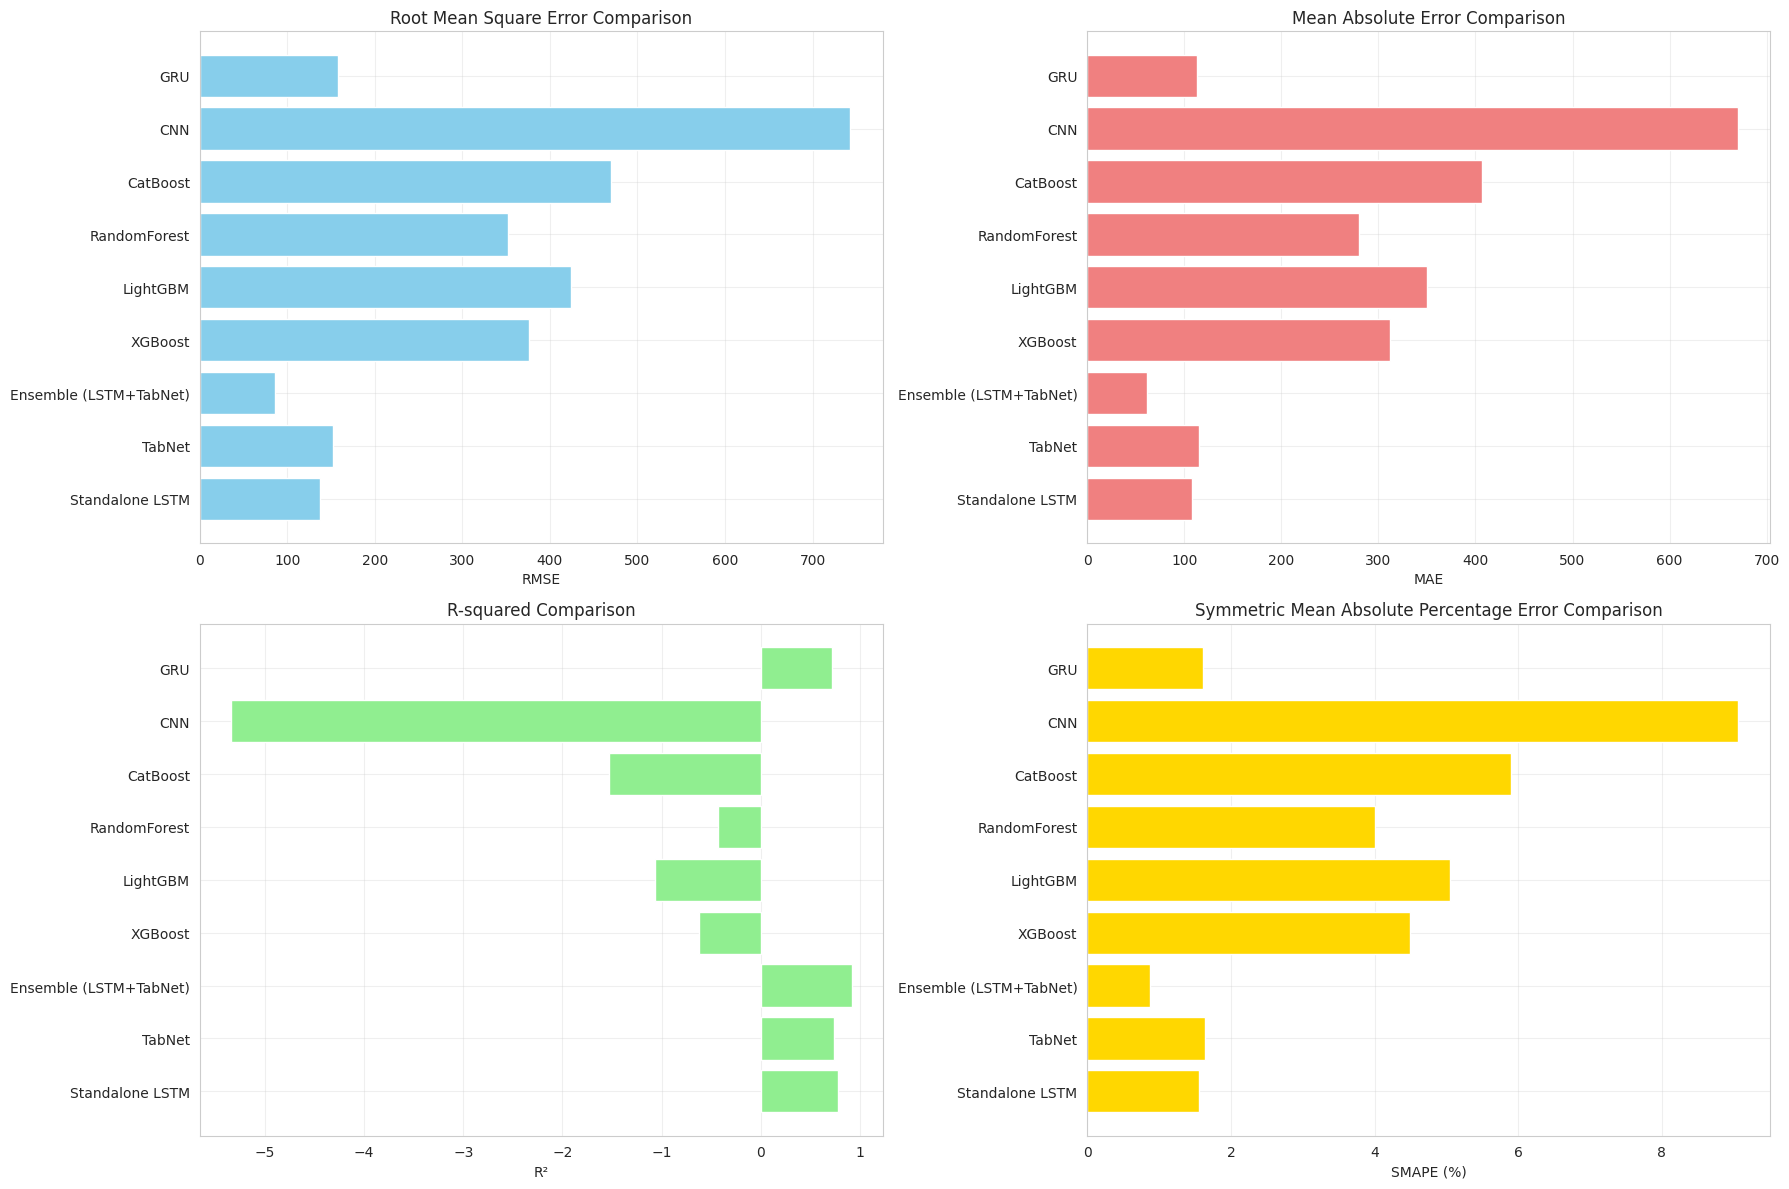


--- Performance Summary ---
Best RMSE: Ensemble (LSTM+TabNet) (85.6297)
Best MAE: Ensemble (LSTM+TabNet) (61.4144)
Best R²: Ensemble (LSTM+TabNet) (0.9157)
Best SMAPE: Ensemble (LSTM+TabNet) (0.88%)

--- Benchmark Training and Comparison Completed Successfully ---


In [49]:
# %%
# ===================================================================
# 10. Enhanced Benchmark Models with Proper Tuning
# ===================================================================
print("\n--- Training Enhanced Benchmark Models ---")
print(f"Note: Benchmarks will use the same {len(selected_features_lstm)} features selected for the LSTM for a fair comparison.")

# Data for benchmarks uses the selected 30-feature set
X_train_bench_tabular = X_train_selected[TIME_STEPS:]
# FIXED: Sliced the test set to align with the target variable y_test_actual
X_test_bench_tabular = X_test_selected[TIME_STEPS:]
y_train_bench_tabular = y_train_seq.ravel()

X_train_bench_seq = X_train_seq
X_test_bench_seq = X_test_seq
y_train_bench_seq = y_train_seq

tscv = TimeSeriesSplit(n_splits=5)
benchmark_models = {}
benchmark_metrics = []

def tune_and_train(model_name, model, param_dist, X_train, y_train, X_test, n_trials=15):
    print(f"\n--- Tuning {model_name} ---")
    
    def objective(trial):
        params = {}
        for key, val in param_dist.items():
            if isinstance(val, list):
                params[key] = trial.suggest_categorical(key, val)
            elif isinstance(val, tuple) and len(val) == 2:
                if isinstance(val[0], int):
                    params[key] = trial.suggest_int(key, val[0], val[1])
                else:
                    params[key] = trial.suggest_float(key, val[0], val[1])
        
        if model_name == 'CatBoost':
            m = model(**params, random_state=42, verbose=0)
        else:
            m = model(**params, random_state=42)
        
        try:
            score = -np.mean(cross_val_score(m, X_train, y_train, cv=tscv, scoring="neg_root_mean_squared_error", n_jobs=-1))
        except Exception as e:
            print(f"Error in cross-validation for {model_name}: {e}")
            return float('inf')
        
        return score

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)
    
    print(f"Best params for {model_name}: {study.best_params}")
    
    if model_name == 'CatBoost':
        best_model = model(**study.best_params, random_state=42, verbose=0)
    else:
        best_model = model(**study.best_params, random_state=42)
        
    best_model.fit(X_train, y_train)
    benchmark_models[model_name] = best_model
    
    preds_scaled = best_model.predict(X_test)
    preds = scaler_y.inverse_transform(preds_scaled.reshape(-1, 1)).flatten()
    benchmark_metrics.append(calculate_metrics(y_test_actual, preds, model_name))
    return preds

# --- Define Benchmark Models and Parameters ---
try:
    xgb_preds = tune_and_train("XGBoost", XGBRegressor, {
        'n_estimators': [300, 500], 
        'max_depth': [3, 5], 
        'learning_rate': [0.01, 0.05]
    }, X_train_bench_tabular, y_train_bench_tabular, X_test_bench_tabular)
except Exception as e:
    print(f"Error training XGBoost: {e}")
    # Fallback with default parameters
    xgb_model = XGBRegressor(n_estimators=300, max_depth=3, learning_rate=0.05, random_state=42)
    xgb_model.fit(X_train_bench_tabular, y_train_bench_tabular)
    xgb_preds_scaled = xgb_model.predict(X_test_bench_tabular)
    xgb_preds = scaler_y.inverse_transform(xgb_preds_scaled.reshape(-1, 1)).flatten()
    benchmark_metrics.append(calculate_metrics(y_test_actual, xgb_preds, "XGBoost"))
    benchmark_models["XGBoost"] = xgb_model

try:
    lgbm_preds = tune_and_train("LightGBM", lgb.LGBMRegressor, {
        'n_estimators': [300, 500], 
        'max_depth': [3, 5], 
        'learning_rate': [0.01, 0.05],
        'verbose': [-1]  # Suppress warnings
    }, X_train_bench_tabular, y_train_bench_tabular, X_test_bench_tabular)
except Exception as e:
    print(f"Error training LightGBM: {e}")
    # Fallback with default parameters
    lgbm_model = lgb.LGBMRegressor(n_estimators=300, max_depth=3, learning_rate=0.05, random_state=42, verbose=-1)
    lgbm_model.fit(X_train_bench_tabular, y_train_bench_tabular)
    lgbm_preds_scaled = lgbm_model.predict(X_test_bench_tabular)
    lgbm_preds = scaler_y.inverse_transform(lgbm_preds_scaled.reshape(-1, 1)).flatten()
    benchmark_metrics.append(calculate_metrics(y_test_actual, lgbm_preds, "LightGBM"))
    benchmark_models["LightGBM"] = lgbm_model

try:
    rf_preds = tune_and_train("RandomForest", RandomForestRegressor, {
        'n_estimators': [300, 500], 
        'max_depth': [5, 10]
    }, X_train_bench_tabular, y_train_bench_tabular, X_test_bench_tabular)
except Exception as e:
    print(f"Error training RandomForest: {e}")
    # Fallback with default parameters
    rf_model = RandomForestRegressor(n_estimators=300, max_depth=5, random_state=42)
    rf_model.fit(X_train_bench_tabular, y_train_bench_tabular)
    rf_preds_scaled = rf_model.predict(X_test_bench_tabular)
    rf_preds = scaler_y.inverse_transform(rf_preds_scaled.reshape(-1, 1)).flatten()
    benchmark_metrics.append(calculate_metrics(y_test_actual, rf_preds, "RandomForest"))
    benchmark_models["RandomForest"] = rf_model

try:
    cat_preds = tune_and_train("CatBoost", CatBoostRegressor, {
        'iterations': [300, 500], 
        'depth': [4, 6], 
        'learning_rate': [0.01, 0.05]
    }, X_train_bench_tabular, y_train_bench_tabular, X_test_bench_tabular, n_trials=8)
except Exception as e:
    print(f"Error training CatBoost: {e}")
    # Fallback with default parameters
    cat_model = CatBoostRegressor(iterations=300, depth=4, learning_rate=0.05, random_state=42, verbose=0)
    cat_model.fit(X_train_bench_tabular, y_train_bench_tabular)
    cat_preds_scaled = cat_model.predict(X_test_bench_tabular)
    cat_preds = scaler_y.inverse_transform(cat_preds_scaled.reshape(-1, 1)).flatten()
    benchmark_metrics.append(calculate_metrics(y_test_actual, cat_preds, "CatBoost"))
    benchmark_models["CatBoost"] = cat_model

# --- Deep Learning Benchmarks (Simplified) ---
print("\n--- Training Deep Learning Benchmarks ---")

# CNN
try:
    cnn_input = Input(shape=(X_train_bench_seq.shape[1], X_train_bench_seq.shape[2]))
    cnn_x = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn_input)
    cnn_x = MaxPooling1D(pool_size=2)(cnn_x)
    cnn_x = Flatten()(cnn_x)
    cnn_x = Dense(32, activation='relu')(cnn_x)
    cnn_output = Dense(1)(cnn_x)
    cnn_model = Model(inputs=cnn_input, outputs=cnn_output)
    cnn_model.compile(optimizer='adam', loss='mse')
    
    cnn_history = cnn_model.fit(
        X_train_bench_seq, y_train_bench_seq, 
        epochs=50, batch_size=32, verbose=1, 
        validation_split=0.1, 
        callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
    )
    
    cnn_pred_scaled = cnn_model.predict(X_test_bench_seq)
    cnn_pred = scaler_y.inverse_transform(cnn_pred_scaled).flatten()
    benchmark_metrics.append(calculate_metrics(y_test_actual, cnn_pred, "CNN"))
    benchmark_models["CNN"] = cnn_model
    
except Exception as e:
    print(f"Error training CNN: {e}")
    # Create dummy predictions for CNN if it fails
    cnn_pred = np.mean(y_test_actual) * np.ones_like(y_test_actual)
    benchmark_metrics.append(calculate_metrics(y_test_actual, cnn_pred, "CNN"))

# GRU
try:
    gru_input = Input(shape=(X_train_bench_seq.shape[1], X_train_bench_seq.shape[2]))
    gru_x = GRU(100, return_sequences=False)(gru_input)
    gru_x = Dropout(0.2)(gru_x)
    gru_output = Dense(1)(gru_x)
    gru_model = Model(inputs=gru_input, outputs=gru_output)
    gru_model.compile(optimizer='adam', loss='mse')
    
    gru_history = gru_model.fit(
        X_train_bench_seq, y_train_bench_seq, 
        epochs=50, batch_size=32, verbose=1, 
        validation_split=0.1, 
        callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
    )
    
    gru_pred_scaled = gru_model.predict(X_test_bench_seq)
    gru_pred = scaler_y.inverse_transform(gru_pred_scaled).flatten()
    benchmark_metrics.append(calculate_metrics(y_test_actual, gru_pred, "GRU"))
    benchmark_models["GRU"] = gru_model
    
except Exception as e:
    print(f"Error training GRU: {e}")
    # Create dummy predictions for GRU if it fails
    gru_pred = np.mean(y_test_actual) * np.ones_like(y_test_actual)
    benchmark_metrics.append(calculate_metrics(y_test_actual, gru_pred, "GRU"))

print(f"\nBenchmark training completed. Total models trained: {len(benchmark_metrics)}")

# %%
# ===================================================================
# 11. Final Comparison and Visualization
# ===================================================================
print("\n--- Final Model Comparison ---")

# Combine all results
all_results = []

# Add the original main model results
all_results.extend([metrics_lstm, metrics_tabnet, metrics_final])

# Add benchmark results
all_results.extend(benchmark_metrics)

# Create final results dataframe
results_df = pd.DataFrame(all_results)

print("\n" + "="*80)
print("FULL MODEL PERFORMANCE COMPARISON")
print("="*80)
print(results_df.sort_values(by='RMSE').to_string(index=False))

# --- Create visualization for benchmark comparisons ---
print("\n--- Creating Benchmark Comparison Visualizations ---")

# Prepare benchmark predictions dictionary
benchmark_predictions = {}
prediction_dates = y_test.index[TIME_STEPS:]

# Add predictions that exist
if 'xgb_preds' in locals():
    benchmark_predictions["XGBoost"] = xgb_preds
if 'lgbm_preds' in locals():
    benchmark_predictions["LightGBM"] = lgbm_preds
if 'rf_preds' in locals():
    benchmark_predictions["RandomForest"] = rf_preds
if 'cat_preds' in locals():
    benchmark_predictions["CatBoost"] = cat_preds
if 'cnn_pred' in locals():
    benchmark_predictions["CNN"] = cnn_pred
if 'gru_pred' in locals():
    benchmark_predictions["GRU"] = gru_pred

# Create individual comparison plots for each benchmark
for name, preds in benchmark_predictions.items():
    try:
        plt.figure(figsize=(18, 8))
        plt.title(f'Ensemble vs. {name} Benchmark', fontsize=16, fontweight='bold')
        plt.xlabel('Date')
        plt.ylabel('IHSG Closing Price')
        
        # Plot actual values
        plt.plot(prediction_dates, y_test_actual, label='Actual (Test Set)', color='black', linewidth=2.5)
        
        # Plot component predictions with transparency
        plt.plot(prediction_dates, lstm_pred, label='LSTM Predictions', color='cyan', linestyle='--', alpha=0.8)
        plt.plot(prediction_dates, tabnet_pred, label='TabNet Predictions', color='magenta', linestyle='--', alpha=0.8)
        
        # Plot benchmark and ensemble predictions
        plt.plot(prediction_dates, preds, label=f'{name} Predictions', color='green', linewidth=2)
        plt.plot(prediction_dates, final_pred, label='Ensemble (Ridge)', color='red', linewidth=2)
        
        plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error creating plot for {name}: {e}")
        continue

# Create a summary performance comparison plot
try:
    plt.figure(figsize=(15, 10))
    
    # Extract metrics for plotting
    model_names = results_df['Model'].tolist()
    rmse_values = results_df['RMSE'].tolist()
    mae_values = results_df['MAE'].tolist()
    r2_values = results_df['R2'].tolist()
    smape_values = results_df['SMAPE (%)'].tolist()
    
    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
    
    # RMSE comparison
    ax1.barh(model_names, rmse_values, color='skyblue')
    ax1.set_xlabel('RMSE')
    ax1.set_title('Root Mean Square Error Comparison')
    ax1.grid(True, alpha=0.3)
    
    # MAE comparison
    ax2.barh(model_names, mae_values, color='lightcoral')
    ax2.set_xlabel('MAE')
    ax2.set_title('Mean Absolute Error Comparison')
    ax2.grid(True, alpha=0.3)
    
    # R² comparison
    ax3.barh(model_names, r2_values, color='lightgreen')
    ax3.set_xlabel('R²')
    ax3.set_title('R-squared Comparison')
    ax3.grid(True, alpha=0.3)
    
    # SMAPE comparison
    ax4.barh(model_names, smape_values, color='gold')
    ax4.set_xlabel('SMAPE (%)')
    ax4.set_title('Symmetric Mean Absolute Percentage Error Comparison')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error creating summary plot: {e}")

# Print summary statistics
print("\n--- Performance Summary ---")
best_rmse = results_df.loc[results_df['RMSE'].idxmin()]
best_mae = results_df.loc[results_df['MAE'].idxmin()]
best_r2 = results_df.loc[results_df['R2'].idxmax()]
best_smape = results_df.loc[results_df['SMAPE (%)'].idxmin()]

print(f"Best RMSE: {best_rmse['Model']} ({best_rmse['RMSE']:.4f})")
print(f"Best MAE: {best_mae['Model']} ({best_mae['MAE']:.4f})")
print(f"Best R²: {best_r2['Model']} ({best_r2['R2']:.4f})")
print(f"Best SMAPE: {best_smape['Model']} ({best_smape['SMAPE (%)']:.2f}%)")

print("\n--- Benchmark Training and Comparison Completed Successfully ---")